# W2V 다른 것도 해보기


### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rc('font',family='malgun gothic')
plt.rc('axes',unicode_minus=False)
import seaborn as sns

# EDA
import klib

# Preprocessing&Feature Engineering
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile
from gensim.models import word2vec

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ARDRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

# Eveluation
from sklearn.metrics import mean_squared_error # squared=False시 RMSE
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import pickle

### Read Data

In [2]:
df_train = pd.read_csv(os.path.abspath("../input")+'/X_train.csv', encoding='cp949')
y_train = pd.read_csv(os.path.abspath("../input")+'/y_train.csv', encoding='cp949').set_index('custid')
df_test = pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')
test_id = df_test['custid'].unique()

### Creating Feature&Feature Engineering

In [ ]:
tr = pd.concat([df_train, df_test])
tr.head()

,custid,sales_month,sales_day,sales_dayofweek,sales_time,str_nm,goodcd,brd_nm,corner_nm,pc_nm,part_nm,team_nm,buyer_nm,import_flg,tot_amt,dis_amt,net_amt,inst_mon,inst_fee
0,0,6,25,일,1212,무역점,2116050008000,에스티로더,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,1,90000,9000,81000,3,0
1,0,6,25,일,1242,무역점,4125440008000,시슬리,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,1,39000,3900,35100,1,0
2,0,8,26,토,1810,본점,2116052008000,크리니크,수입종합화장품,화장품,잡화파트,잡화가용팀,화장품,1,175000,17500,157500,3,0
3,0,8,26,토,1830,본점,4106430119900,듀퐁,수입의류,명품토탈,잡화파트,잡화가용팀,수입명품,1,455000,45500,409500,3,0
4,0,9,3,일,1802,무역점,2139141008000,랑콤,수입종합화장품,화장품,명품잡화,잡화가용팀,화장품,0,100000,10000,90000,3,0


### PCA

In [ ]:
# 차원축소 매소드 
from sklearn.decomposition import PCA

def dummy_to_pca(tr, column_name:str) :
    max_seq = 300
    max_d = 15
    col_count = tr.groupby(column_name)[column_name].count()
    if len(col_count) > max_seq:
        tops = col_count.sort_values(ascending=False)[0:max_seq].index
        f =tr.loc[tr[column_name].isin(tops)][['custid', column_name]]
    else:
        tops = col_count.index
        f =tr[['custid', column_name]]
    f = pd.get_dummies(f, columns=[column_name])  # This method performs One-hot-encoding
    f = f.groupby('custid').mean()
    if len(tops) < max_d:
        max_d = len(tops)
    pca = PCA(n_components=max_d)
    pca.fit(f)
    cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
    print(cumsum)
    num_d = np.argmax(cumsum >= 0.99) + 1 # 분산의 설명량이 99%이상 되는 차원의 수
    if num_d == 1:
        num_d = max_d
    pca = PCA(n_components=num_d)    
    result = pca.fit_transform(f)
    result = pd.DataFrame(result)
    result.columns = [column_name + '_' + str(column) for column in result.columns]
    result.index = f.index
    return result.reset_index()

In [ ]:
features=pd.DataFrame({'custid':tr.custid.unique()})
f = dummy_to_pca(tr, 'brd_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'corner_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'pc_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'part_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'buyer_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'team_nm'); features = pd.merge(features,f,on='custid',how='left')
f = dummy_to_pca(tr, 'goodcd'); features = pd.merge(features,f,on='custid',how='left')

[0.20925819 0.26247578 0.31026524 0.35465584 0.39279151 0.42773016
 0.45686994 0.48238291 0.50635612 0.52855114 0.54644828 0.56310481
 0.57731784 0.58944097 0.60093382]
[0.27577009 0.32856671 0.36450786 0.39201514 0.41551164 0.43869649
 0.45870453 0.47724242 0.49342456 0.50875379 0.52285243 0.53626002
 0.54906165 0.56165788 0.57339718]
[0.30258006 0.35534363 0.3974377  0.43719505 0.46332484 0.48755424
 0.51030556 0.53138995 0.55127277 0.57056583 0.58892674 0.60531177
 0.62025263 0.63467199 0.64855063]
[0.1879969  0.36112839 0.48727324 0.5555609  0.61059754 0.65950855
 0.69744239 0.7270648  0.75559643 0.77902548 0.80181542 0.82369288
 0.84361995 0.86291633 0.88030927]
[0.32693065 0.48981179 0.56968538 0.62867222 0.67853989 0.71931297
 0.75523527 0.78396579 0.81148539 0.8370249  0.85987317 0.88190477
 0.90236185 0.92022774 0.9373244 ]
[0.63403846 0.99999985 1.         1.        ]
[0.23542319 0.29690401 0.34967812 0.39710801 0.44266303 0.48309861
 0.51751953 0.54674546 0.57378356 0.597742

## W2V

In [ ]:
def age_vec():
    sentences = []
    df_all = df_train
    for id in tqdm(df_all.custid.unique()):
        x = df_all.query('custid == @id')[level].unique()
        y = y_train.query('custid == @id').age
        for j in range(20):
            y = np.append(y, np.random.choice(x, len(x), replace=False))
        sentences.append(list(y))

### W2V-상품코드

In [ ]:
level = 'goodcd' # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 20배 oversampling을 수행
sentences = []
df_all = pd.concat([df_train, df_test])
for id in tqdm(df_all.custid.unique()):
    uw = df_all.query('custid == @id')[level].unique()
    bs = np.array([])
    for j in range(20):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    sentences.append(list(bs))
    sentences.append(list(df_all.query('custid == @id')[level].values))

100%|████████████████████████████████████████████████████████████████████████████| 35967/35967 [14:58<00:00, 40.02it/s]


In [ ]:
max_features = 200 # 문자 벡터 차원 수
min_word_count = 1 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          vector_size=max_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling,)
# 필요없는 메모리 unload
model.init_sims(replace=True)

In [ ]:
features_wv = []
for id in tqdm(df_train.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_train5 = np.array(features_wv)

features_wv = []
for id in tqdm(df_test.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_test5 = np.array(features_wv)

X_train5 = pd.DataFrame(X_train5)
X_test5 = pd.DataFrame(X_test5)
X_train5.insert(0,'custid',df_train.custid.unique())
X_test5.insert(0,'custid',df_test.custid.unique())

100%|████████████████████████████████████████████████████████████████████████████| 14380/14380 [03:08<00:00, 76.17it/s]


### W2V-PC명

In [ ]:
level = 'pc_nm' # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 20배 oversampling을 수행
sentences = []
df_all = pd.concat([df_train, df_test])
for id in tqdm(df_all.custid.unique()):
    uw = df_all.query('custid == @id')[level].unique()
    bs = np.array([])
    for j in range(20):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    sentences.append(list(bs))
    sentences.append(list(df_all.query('custid == @id')[level].values))

100%|████████████████████████████████████████████████████████████████████████████| 35967/35967 [15:53<00:00, 37.71it/s]


In [ ]:
max_features = 30 # 문자 벡터 차원 수
min_word_count = 1 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          vector_size=max_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling,)
# 필요없는 메모리 unload
model.init_sims(replace=True)

In [ ]:
features_wv = []
for id in tqdm(df_train.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_train4 = np.array(features_wv)

features_wv = []
for id in tqdm(df_test.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_test4 = np.array(features_wv)

X_train4 = pd.DataFrame(X_train4)
X_test4 = pd.DataFrame(X_test4)
X_train4.insert(0,'custid',df_train.custid.unique())
X_test4.insert(0,'custid',df_test.custid.unique())

100%|████████████████████████████████████████████████████████████████████████████| 14380/14380 [03:12<00:00, 74.80it/s]


### W2V-코너명

In [ ]:
level = 'corner_nm' # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 20배 oversampling을 수행
sentences = []
df_all = pd.concat([df_train, df_test])
for id in tqdm(df_all.custid.unique()):
    uw = df_all.query('custid == @id')[level].unique()
    bs = np.array([])
    for j in range(20):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    sentences.append(list(bs))
    sentences.append(list(df_all.query('custid == @id')[level].values))

In [ ]:
max_features = 300 # 문자 벡터 차원 수
min_word_count = 1 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
#                           size=max_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
# 필요없는 메모리 unload
model.init_sims(replace=True)

In [ ]:
# Make features based on Word2Vec
# 고객별로 구매한 상품의 평균벡터를 feature로 사용한다.
features_wv = []
for id in tqdm(df_train.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_train2 = np.array(features_wv)

features_wv = []
for id in tqdm(df_test.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_test2 = np.array(features_wv)

X_train2 = pd.DataFrame(X_train2)
X_test2 = pd.DataFrame(X_test2)
X_train2.insert(0,'custid',df_train.custid.unique())
X_test2.insert(0,'custid',df_test.custid.unique())

### W2V-브랜드명

In [ ]:
### W2V-브랜드명
level = 'brd_nm' # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 20배 oversampling을 수행
sentences = []
df_all = pd.concat([df_train, df_test])
for id in tqdm(df_all.custid.unique()):
    uw = df_all.query('custid == @id')[level].unique()
    bs = np.array([])
    for j in range(20):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    sentences.append(list(bs))
    sentences.append(list(df_all.query('custid == @id')[level].values))

100%|████████████████████████████████████████████████████████████████████████████| 35967/35967 [15:47<00:00, 37.94it/s]


In [ ]:
max_features = 300 # 문자 벡터 차원 수
min_word_count = 1 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
#                           vector_size=max_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
# 필요없는 메모리 unload
model.init_sims(replace=True)

In [ ]:
# Make features based on Word2Vec
# 고객별로 구매한 상품의 평균벡터를 feature로 사용한다.
features_wv = []
for id in tqdm(df_train.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_train3 = np.array(features_wv)

features_wv = []
for id in tqdm(df_test.custid.unique()):
    features_wv.append(df_all.query('custid == @id')[level] \
                              .apply(lambda x: model.wv[x]).mean())
X_test3 = np.array(features_wv)

100%|████████████████████████████████████████████████████████████████████████████| 14380/14380 [03:13<00:00, 74.20it/s]


In [ ]:
X_train3 = pd.DataFrame(X_train3)
X_test3 = pd.DataFrame(X_test3)
X_train3.insert(0,'custid',df_train.custid.unique())
X_test3.insert(0,'custid',df_test.custid.unique())

In [ ]:
X_train2 = pd.read_excel('X_train2.xlsx',index_col=0)
X_test2 = pd.read_excel('X_test2.xlsx',index_col=0)
X_train3 = pd.read_excel('X_train3.xlsx',index_col=0)
X_test3 = pd.read_excel('X_test3.xlsx',index_col=0)
X_train4 = pd.read_excel('X_train4.xlsx',index_col=0)
X_test4 = pd.read_excel('X_test4.xlsx',index_col=0)
X_train5 = pd.read_excel('X_train5.xlsx',index_col=0)
X_test5 = pd.read_excel('X_test5.xlsx',index_col=0)

In [ ]:
def month_modify(x):
    if x > 12:
        return x-12
    else:
        return x

def extract_hour(x):
    if len(str(x))>3:
        return str(x)[:2]
    else: 
        return str(x)[:1]
def extract_season(x):
    if 3 <= x <= 5 :
        return('봄')
    elif 6 <= x <= 8 :
        return('여름')
    elif 9 <= x <= 11 :    
        return('가을')
    else :
        return('겨울') 
def time_(x):
    if 9 <= x <= 11 :
        return('아침_구매건수')
    elif 12 <= x <= 17 :
        return('점심_구매건수')
    else :
        return('저녁_구매건수')
def half_year(x):
    if 1<=x<=5:
        return('전반기')
    else:
        return('후반기')
def peak_season(x):
    if x in [7,8,12,1,2]:
        return('성수기')
    else:
        return('비성수기')
def div_month(x):
    if 1<=x<=10:
        return('월초')
    elif 11<=x<=20:
        return('월중')
    else:
        return('월말')
def noon(x):
    if int(str(x)[-2:])<=12:
        return('오전')
    else:
        return('오후')

일반변수

In [ ]:
df = tr.copy()
df['sales_hour'] = df.sales_time.apply(extract_hour)
df['sales_hour'] = pd.to_numeric(df['sales_hour'])
df['sales_hour'] = np.where(df['sales_hour'] < 9, 21, df['sales_hour'])
df['방문시간대'] = df.sales_hour.apply(time_)
df['sales_month'] = df.sales_month.apply(month_modify)
df['반기'] = df.sales_month.apply(half_year)
df['성수기여부'] = df.sales_month.apply(peak_season)
df['월_초중말'] = df.sales_day.apply(div_month)
df['오전/오후'] = df.sales_time.apply(noon)

# 총구매액
f = df.groupby('custid')['tot_amt'].agg([('총구매액', 'sum')]).reset_index()
features = pd.merge(features,f, on = 'custid')
# 평균구매액
f = df.groupby('custid')['tot_amt'].agg([('평균구매액', 'mean')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 총할인금액
f = pd.DataFrame(df.groupby('custid').dis_amt.sum()).rename(columns={'dis_amt':'총할인금액'})
features = pd.merge(features,f, on = 'custid')
# 평균할인금액
f = pd.DataFrame(df.groupby('custid').dis_amt.mean()).rename(columns={'dis_amt':'평균할인금액'})
features = pd.merge(features,f, on = 'custid')

# 총실구매액
f = pd.DataFrame(df.groupby('custid').net_amt.sum()).rename(columns={'net_amt':'총실구매액'})
features = pd.merge(features,f, on = 'custid')
# 평균실구매액
f = pd.DataFrame(df.groupby('custid').net_amt.mean()).rename(columns={'net_amt':'평균실구매액'})
features = pd.merge(features,f, on = 'custid')

# 요일별 방문횟수
f = pd.crosstab(df.custid,df.sales_dayofweek, margins=True).reindex(columns=['월','화','수',
                                                        '목','금','토','일','All']).iloc[:-1,:].rename(columns={'All':'총방문횟수'})
features = pd.merge(features,f, on = 'custid')

# 시간별 방문횟수
f = pd.crosstab(df.custid, df.sales_hour).rename(columns=dict(zip(df.sales_hour.unique(),[str(i)+'시방문' for i in df.sales_hour.unique()])))
features = pd.merge(features,f, on = 'custid')

# 수입상품 구매 건수
f = pd.DataFrame(df.groupby('custid').import_flg.sum()).rename(columns={'import_flg':'수입상품구매건수'})
features = pd.merge(features,f, on = 'custid')

# x = df[df['import_flg'] == 1].groupby('custid').size()
# f = x.reset_index().rename(columns={0: '수입상품_구매건수'}).fillna(0)
# features = pd.merge(features,f, on = 'custid')

# 구매건수
f = df.groupby('custid')['tot_amt'].agg([('구매건수', 'size')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 평균할부개월수
f = df.groupby('custid')['inst_mon'].agg([('평균할부개월수', 'mean')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 지점별 방문횟수
f = pd.crosstab(df.custid, df.str_nm).rename(columns=dict(zip(df.str_nm.unique(),[i+'방문' for i in df.str_nm.unique()])))
features = pd.merge(features,f, on = 'custid')

# 방문지점 수
f = df.groupby('custid')['str_nm'].agg([('방문지점수',lambda x: x.nunique())])
features = pd.merge(features,f, on = 'custid')

# 월별 구매횟수
f = pd.crosstab(df.custid,df.sales_month).rename(columns=dict(zip(df.sales_month.unique(), [str(i)+'월방문' for i in df.sales_month.unique()])))
features = pd.merge(features,f, on = 'custid')

# 구매일수
df['sales_month'] = df['sales_month'].astype(str)
df['sales_day'] = df['sales_day'].astype(str)
df['판매일'] = df['sales_month'] + '-' + df['sales_day']
df.판매일 = pd.to_datetime(df.판매일,format='%m-%d')
f = df.groupby(by = 'custid')['판매일'].agg([('구매일수','nunique')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 구매주기
f = df.groupby('custid')['판매일'].agg([('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.nunique()))]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 최고 구입 금액
f = df.groupby('custid')['tot_amt'].agg([('최고구매금액', 'max')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 계절별 구매건수
df['sales_month'] = pd.to_numeric(df['sales_month'])
df['계절'] = df.sales_month.apply(extract_season)
f = pd.pivot_table(df, index = 'custid', columns = '계절', values = 'tot_amt',
                  aggfunc = np.size, fill_value = 0).reset_index()
features = pd.merge(features,f, on = 'custid')

# 반기별 구매건수
f = pd.crosstab(df.custid, df.반기).reset_index()
features = pd.merge(features,f, on = 'custid')

# 성수기 여부 별 구매건수
f = pd.crosstab(df.custid, df.성수기여부).reset_index()
features = pd.merge(features,f, on = 'custid')

# 월 시기별 구매건수
f = pd.crosstab(df.custid, df.월_초중말).reset_index()
features = pd.merge(features,f, on = 'custid')

# 오전/오후별 구매건수
f = pd.crosstab(df.custid, df['오전/오후']).reset_index()
features = pd.merge(features,f, on = 'custid')

# 방문지점 갯수
f = df.groupby(by = 'custid')['str_nm'].agg([('방문지점개수','nunique')]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 구매상품 다양성
n = df.corner_nm.nunique()
f = df.groupby('custid')['goodcd'].agg([('구매상품다양성', lambda x: len(x.unique()) / n)]).reset_index()
features = pd.merge(features,f, on = 'custid')

# 시간대별 방문횟수
f = pd.crosstab(df.custid, df.방문시간대)
features = pd.merge(features,f, on = 'custid')

# 주구매코너
#f = df.groupby('custid')['corner_nm'].agg([('주구매코너', lambda x: x.value_counts().index[0])]).reset_index()
#f = pd.get_dummies(f, columns=['주구매코너'])  # This method performs One-hot-encoding
#features = pd.merge(features,f, on = 'custid')

# 코너별 구매건수
f = pd.pivot_table(df, index='custid', columns='part_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')

# 바이어 이름 별 구매건수
f = pd.pivot_table(df, index='custid', columns='buyer_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0)
f = f.rename(columns=dict(zip(f.columns,[i+'_구매건수' for i in f.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')

# 무이자 할부 평균 가격
f = df.loc[df.inst_fee==1].groupby('custid').net_amt.agg([('무이자할부평균가격','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left').fillna(0)

# 할부결제건수
f = df.loc[df.inst_mon>1].groupby('custid').inst_mon.agg([('할부결제건수','count')])
features = pd.merge(features,f,on='custid',how='left').fillna(0)

# 내점 당 구매금액
f = df.groupby(['custid','판매일'])['tot_amt'].sum().reset_index().groupby('custid')['tot_amt'].agg([('내점당구매금액','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left')

# 내점 당 구매개수
f = df.groupby(['custid','판매일'])['tot_amt'].count().reset_index().groupby('custid')['tot_amt'].agg([('내점당구매개수','mean')]).reset_index()
features = pd.merge(features,f,on='custid',how='left')

# 평균쇼핑시간
f = df.groupby(['custid','판매일'])['sales_time'].agg(lambda x: x.max()-x.min()).reset_index().groupby('custid').sales_time.agg([('평균쇼핑시간','mean')])
features = pd.merge(features,f,on='custid',how='left')







f = pd.pivot_table(df, index='custid', columns='brd_nm', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()
del f['custid']
pca = PCA(n_components=5, random_state=0)
f_pca = pca.fit_transform(f)
f = pd.DataFrame(f_pca)
features = pd.concat([features,f], axis = 1)


f = pd.pivot_table(df, index='custid', columns='brd_nm', values='tot_amt', 
                   aggfunc='sum', fill_value=0).reset_index()
del f['custid']
pca = PCA(n_components=150, random_state=0)
f_pca = pca.fit_transform(f)
f = pd.DataFrame(f_pca)
features = pd.concat([features,f], axis = 1)

비율변수

In [ ]:
features['custid'] = tr.custid.unique()

tr['sales_hour'] = tr.sales_time.apply(extract_hour)
weekdays = pd.crosstab(tr.custid,tr.sales_dayofweek, margins=True).reindex(columns=['월','화','수',
                                                        '목','금','토','일','All']).iloc[:-1,:].rename(columns={'All':'총방문횟수'})
sales_hour = pd.crosstab(df.custid, df.sales_hour, margins=True)
sales_hour = sales_hour.rename(columns=dict(zip(sales_hour.columns,[str(i)+'시방문' for i in sales_hour.columns])))
str_nm = pd.crosstab(tr.custid, tr.str_nm,margins=True)
str_nm = str_nm.rename(columns=dict(zip(str_nm.columns,[i+'방문' for i in str_nm.columns])))
sales_month = pd.crosstab(df.custid,df.sales_month, margins=True)
sales_month = sales_month.rename(columns=dict(zip(sales_month.columns, [str(i)+'월방문' for i in sales_month])))
tr['sales_month'] = pd.to_numeric(tr['sales_month'])
tr['sales_month'] = tr.sales_month.apply(month_modify)
tr['season'] = pd.DataFrame(tr.sales_month.apply(extract_season))
season_visit = pd.crosstab(tr.custid, tr.season)
tr['mln'] = tr.sales_time.apply(lambda x: int(str(x)[:2])).apply(time_)
mln = pd.crosstab(tr.custid, tr.mln,margins=True)
inv = tr.loc[tr.inst_mon>1].groupby('custid').inst_mon.agg([('할부결제건수','count')])
trans_amount = tr.groupby('custid')['tot_amt'].agg([('구매건수', 'size')])
peak = pd.crosstab(df.custid, df.성수기여부, margins=True)
peak = peak.divide(peak.iloc[:,-1],axis=0).iloc[:-1,:-1]
half = pd.crosstab(df.custid, df.반기, margins=True)
half = half.divide(half.iloc[:,-1],axis=0).iloc[:-1,:-1]
noon = pd.crosstab(df.custid, df['오전/오후'], margins=True)
noon = noon.divide(noon.iloc[:,-1],axis=0).iloc[:-1,:-1]

In [ ]:
# 수입상품 구매비율
x = df[df['import_flg'] == 1].groupby('custid').size() / df.groupby('custid').size()
f = x.reset_index().rename(columns={0: '수입상품구매비율'}).fillna(0)
f.iloc[:,1] = (f.iloc[:,1])
features = pd.merge(features,f, on = 'custid')

# 주말 방문 비율
day_to_int = {
    '월': 1,'화': 2,'수': 3,'목': 4,'금': 5,'토': 6,'일': 7}
df2 = df.copy()
df2['sales_dayofweek'] = df2['sales_dayofweek'].map(day_to_int)
df2 = pd.pivot_table(df, index='custid', columns='sales_dayofweek', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index();
df2['주말방문비율'] = ((df2.iloc[:,5]+df2.iloc[:,6]) / (df2.iloc[:,1]+df2.iloc[:,2]+df2.iloc[:,3]+df2.iloc[:,4]+
                                                df2.iloc[:,5]+df2.iloc[:,6]+df2.iloc[:,7]))
f = df2[['custid','주말방문비율']]
features = pd.merge(features,f, on = 'custid')

# 요일별 방문비율
f = weekdays.iloc[:,:-1].divide(weekdays.iloc[:,-1], axis=0).rename(columns=dict(zip(weekdays.columns,
                                                                                    [str(i)+'_prop' for i in weekdays.columns])))
features = pd.merge(features,f, on = 'custid')

# 시간별 방문비율
f = sales_hour.iloc[:-1,:-1].divide(sales_hour.iloc[:-1,-1],axis=0).rename(columns=dict(zip(sales_hour.columns,
                                                                                    [str(i)+'_prop' for i in sales_hour.columns])))
features = pd.merge(features,f, on = 'custid')
# 지점별 방문비율
f = str_nm.iloc[:-1,:-1].divide(str_nm.iloc[:-1,-1],axis=0).rename(columns=dict(zip(str_nm.columns,[str(i)+'_prop' for i in str_nm.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 구매월별 방문비율
f = sales_month.iloc[:-1,:-1].divide(sales_month.iloc[:-1,-1],axis=0).rename(columns=
                                                        dict(zip(sales_month.columns,[str(i)+'_prop' for i in sales_month.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 계절별 방문비율
f = season_visit.divide(weekdays.총방문횟수,axis=0).rename(columns=dict(zip(season_visit.columns,[column+'_prop' for column in season_visit.columns]))).reset_index()
features = pd.merge(features,f, on = 'custid')
# 시간대별 방문비율
f = mln.div(mln.iloc[:,-1], axis=0).iloc[:-1,:-1].reset_index().rename(columns=dict(zip(mln.columns,[i+'_prop' for i in mln.columns])))
features = pd.merge(features,f, on = 'custid')
# 할부결제비율
f =(inv['할부결제건수']/trans_amount['구매건수']).reset_index().rename(columns={0:'할부결제비율'}).fillna(0)
features = pd.merge(features,f, on = 'custid')
# 성수기 방문비율
f = peak.iloc[:,1].reset_index().rename(columns={'성수기':'성수기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 비성수기 방문비율
f = peak.iloc[:,0].reset_index().rename(columns={'비성수기':'비성수기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 전반기 방문비율
f = half.iloc[:,0].reset_index().rename(columns={'전반기':'전반기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 후반기 방문비율
f = half.iloc[:,1].reset_index().rename(columns={'후반기':'후반기방문비율'})
features = pd.merge(features,f, on = 'custid')
# 오전 방문비율
f = noon.iloc[:,0].reset_index().rename(columns={'오전':'오전방문비율'})
features = pd.merge(features,f, on = 'custid')
# 오후 방문비율
f = noon.iloc[:,1].reset_index().rename(columns={'오후':'오후방문비율'})
features = pd.merge(features,f, on = 'custid')
# 할인율 평균
df['할인율'] = df.dis_amt/df.tot_amt
f = df.groupby('custid')['할인율'].mean().reset_index()
features = pd.merge(features,f,on='custid',how='left')

In [ ]:
del features['custid']

In [ ]:
# 이상치 처리
features = features.apply(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)), axis=0)

# 표준화
features.loc[:,:] = RobustScaler().fit_transform(features)

In [ ]:
features['custid'] = tr.custid.unique()

In [ ]:
X_train = pd.DataFrame({'custid': df_train.custid.unique()})
X_train = pd.merge(X_train, features, how='left', on='custid')

X_test = pd.DataFrame({'custid': df_test.custid.unique()})
X_test = pd.merge(X_test, features, how='left', on='custid')

merge W2V

In [ ]:
X_train = pd.merge(X_train, X_train2, how='left', on='custid')
X_train = X_train.set_index('custid')
X_test = pd.merge(X_test, X_test2, how='left', on='custid')
X_test = X_test.set_index('custid')

In [ ]:
X_train = pd.merge(X_train, X_train3, how='left', on='custid')
X_train = X_train.set_index('custid')
X_test = pd.merge(X_test, X_test3, how='left', on='custid')
X_test = X_test.set_index('custid')

In [ ]:
X_train = pd.merge(X_train, X_train4, how='left', on='custid')
X_train = X_train.set_index('custid')
X_test = pd.merge(X_test, X_test4, how='left', on='custid')
X_test = X_test.set_index('custid')

In [ ]:
X_train = pd.merge(X_train, X_train5, how='left', on='custid')
X_train = X_train.set_index('custid')
X_test = pd.merge(X_test, X_test5, how='left', on='custid')
X_test = X_test.set_index('custid')

One-hot Encoding

In [ ]:
level = 'corner_nm'
df_train[level].nunique()
IDtest = df_test.custid.unique()

df_all = pd.concat([df_train, df_test])
x_train = pd.pivot_table(df_all, index='custid', columns=level, values='tot_amt',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('custid not in @IDtest'). \
                         set_index('custid')
x_test = pd.pivot_table(df_all, index='custid', columns=level, values='tot_amt',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('custid in @IDtest'). \
                         set_index('custid')

x_train = pd.merge(x_train, X_train, on = 'custid')
x_test = pd.merge(x_test, X_test, on = 'custid')

### Feature Selection

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [08:49<00:00,  5.57s/it]


(53, -71.02138334429993)


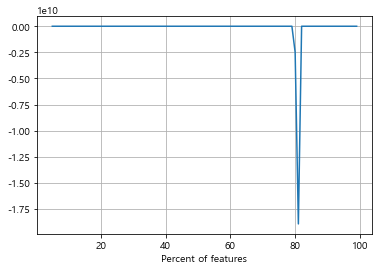

In [ ]:
features = x_train
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LinearRegression()

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
# feature 개수 바꿔가며 성능 test한다.
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(x_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_mean_squared_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [ ]:
-70.99788356506613
(41, -70.84265044169952)


(41, -70.84265044169952)

In [ ]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(x_train, y_train)
x_train = fs.transform(x_train)
x_test = fs.transform(x_test)

print(x_train.shape)
print(features.columns[fs.get_support()].tolist())

(21587, 624)
['가스렌지', '가정잡화', '건강식품', '건식품', '건어물', '곡물', '골프(LC)', '골프(NB)', '골프(국내)', '골프(수입)', '골프단품', '골프웨어', '교복행사', '국내부띠끄', '냉장식품', '단품', '디자이너니트', '디자이너숍', '라이센스', '레이디숍A', '레포츠', '로얄부틱2F', '로얄수입행사', '문화', '부띠끄', '생선', '셔츠', '수예행사', '수입도자기', '수입부띠끄', '슈즈', '스포츠슈즈', '스포츠웨어', '신생아', '아동', '아동단품', '아동복', '아동잡화', '아동특선', '야채', '어덜트', '엘레강스', '엘레강스부틱', '영캐주얼', '완구', '완구(문화)', '욕실용품', '용기보증', '유아', '유아복', '유아용품', '일반조리', '일용잡화', '임대골프', '잡화(문화)', '정육', '조미료', '주방용품', '진캐주얼', '진캐쥬얼', '청과', '침구', '타운단품', '타운웨어', '트래디셔널', '홈쇼핑', 'brd_nm_0', 'brd_nm_9', 'brd_nm_10', 'brd_nm_11', 'brd_nm_12', 'corner_nm_0', 'corner_nm_1', 'corner_nm_2', 'corner_nm_3', 'corner_nm_4', 'corner_nm_5', 'corner_nm_7', 'corner_nm_10', 'corner_nm_12', 'corner_nm_13', 'corner_nm_14', 'pc_nm_0', 'pc_nm_1', 'pc_nm_2', 'pc_nm_3', 'pc_nm_4', 'pc_nm_7', 'pc_nm_8', 'pc_nm_9', 'pc_nm_10', 'part_nm_0', 'part_nm_2', 'part_nm_3', 'part_nm_5', 'part_nm_6', 'part_nm_8', 'part_nm_9', 'part_nm_10', 'part_nm_12', 'part_nm_14', '

```python
pd.DataFrame(x_train,columns=features.columns[fs.get_support()].tolist()).to_csv('x_train0606.csv')
pd.DataFrame(x_test,columns=features.columns[fs.get_support()].tolist()).to_csv('x_train0606.csv')
```

### Model Tuning

In [ ]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

In [ ]:
clfs = [
    (
    LinearRegression(),
    {
        
    }),
        (
    Ridge(random_state=0),
    {
        'alpha':[1]
    }),
        (
    Lasso(random_state=0),
    {
        'alpha':[0.010101010101010102]
    }),
        (
    ElasticNet(random_state=0),
    {
        'alpha':[0.010101010101010102]
    }),
#         (
#     ARDRegression(),
#     {
#         'alpha_1':[0],
#         'alpha_2':[1],
#         'lambda_1':[1],
#         'lambda_2':[0.6333]
#     }),
        (
    BayesianRidge(),
    {
        'alpha_1':[0.7272727272727273],
        'alpha_2':[0.030303030303030304],
        'lambda_1':[0.9494949494949496],
        'lambda_2':[0.9494949494949496]
    }),
#         (
#     RandomForestRegressor(random_state=0),
#     {
#         'n_estimators':[400],
#         'max_depth':[None]
#     }),
        (
    XGBRegressor(random_state=0),
    {
        'n_estimators':[400],
        'learning_rate':[0.1],
        'max_depth':[3],
        'gamma':[0.7272727272727273],
        'reg_alpha':[0.9494949494949496],
        'reg_lambda':[0.9494949494949496]
    }),
        (
    LGBMRegressor(random_state=0),
    {
        'n_estimators':[200],
        'num_leaves':[90],
        'learning_rate':[0.1],
        'max_depth':[5],
        'reg_alpha':[0.56],
        'reg_lambda':[0.73]
        
    }),
        (
    CatBoostRegressor(random_state=0),
    {
        
    })
]
clfs_tuned = []
for clf, param_grid in tqdm(clfs):
    start = time.time()
    grid_search = GridSearchCV(clf, param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    clf_name = type(clf).__name__
    clf_score = np.sqrt(-grid_search.score(x_dev, y_dev))
    clfs_tuned.append([clf_name, grid_search, clf_score])
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))

 11%|█████████▎                                                                          | 1/9 [00:08<01:05,  8.22s/it]

LinearRegression                                     8.404527 8.2


 22%|██████████████████▋                                                                 | 2/9 [00:09<00:42,  6.10s/it]

Ridge                                                8.371922 1.1


 33%|████████████████████████████                                                        | 3/9 [00:42<01:24, 14.11s/it]

Lasso                                                8.446066 32.8


 44%|█████████████████████████████████████▎                                              | 4/9 [01:10<01:31, 18.39s/it]

ElasticNet                                           8.440220 28.4


 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:14<03:20, 50.12s/it]

ARDRegression                                        8.393646 124.2


 67%|████████████████████████████████████████████████████████                            | 6/9 [03:23<01:53, 37.73s/it]

BayesianRidge                                        8.433463 8.8


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [11:11<05:33, 166.86s/it]

XGBRegressor                                         8.378911 468.2


 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [11:56<02:10, 130.31s/it]

LGBMRegressor                                        8.346092 45.0
Learning rate set to 0.063286
0:	learn: 10.2714428	total: 169ms	remaining: 2m 49s
1:	learn: 10.1274113	total: 282ms	remaining: 2m 20s
2:	learn: 9.9935588	total: 374ms	remaining: 2m 4s
3:	learn: 9.8746278	total: 481ms	remaining: 1m 59s
4:	learn: 9.7679042	total: 617ms	remaining: 2m 2s
5:	learn: 9.6608020	total: 716ms	remaining: 1m 58s
6:	learn: 9.5683920	total: 807ms	remaining: 1m 54s
7:	learn: 9.4807077	total: 904ms	remaining: 1m 52s
8:	learn: 9.4090495	total: 999ms	remaining: 1m 49s
9:	learn: 9.3378620	total: 1.1s	remaining: 1m 48s
10:	learn: 9.2762094	total: 1.19s	remaining: 1m 47s
11:	learn: 9.2162889	total: 1.29s	remaining: 1m 45s
12:	learn: 9.1664835	total: 1.38s	remaining: 1m 44s
13:	learn: 9.1120753	total: 1.47s	remaining: 1m 43s
14:	learn: 9.0647561	total: 1.58s	remaining: 1m 43s
15:	learn: 9.0237105	total: 1.7s	remaining: 1m 44s
16:	learn: 8.9854952	total: 1.83s	remaining: 1m 45s
17:	learn: 8.9419561	total: 2.0

156:	learn: 7.8175454	total: 17.1s	remaining: 1m 31s
157:	learn: 7.8136531	total: 17.2s	remaining: 1m 31s
158:	learn: 7.8084907	total: 17.3s	remaining: 1m 31s
159:	learn: 7.8041347	total: 17.4s	remaining: 1m 31s
160:	learn: 7.7993606	total: 17.5s	remaining: 1m 31s
161:	learn: 7.7949477	total: 17.6s	remaining: 1m 31s
162:	learn: 7.7891018	total: 17.7s	remaining: 1m 31s
163:	learn: 7.7839388	total: 17.9s	remaining: 1m 31s
164:	learn: 7.7784484	total: 18s	remaining: 1m 31s
165:	learn: 7.7747313	total: 18.1s	remaining: 1m 30s
166:	learn: 7.7702431	total: 18.2s	remaining: 1m 30s
167:	learn: 7.7667484	total: 18.3s	remaining: 1m 30s
168:	learn: 7.7616221	total: 18.4s	remaining: 1m 30s
169:	learn: 7.7577508	total: 18.5s	remaining: 1m 30s
170:	learn: 7.7530052	total: 18.6s	remaining: 1m 30s
171:	learn: 7.7479222	total: 18.7s	remaining: 1m 30s
172:	learn: 7.7439204	total: 18.8s	remaining: 1m 30s
173:	learn: 7.7397000	total: 19s	remaining: 1m 29s
174:	learn: 7.7348459	total: 19.1s	remaining: 1m 2

312:	learn: 7.1340377	total: 34.6s	remaining: 1m 15s
313:	learn: 7.1295588	total: 34.7s	remaining: 1m 15s
314:	learn: 7.1251108	total: 34.8s	remaining: 1m 15s
315:	learn: 7.1208599	total: 34.9s	remaining: 1m 15s
316:	learn: 7.1165894	total: 35s	remaining: 1m 15s
317:	learn: 7.1131894	total: 35.1s	remaining: 1m 15s
318:	learn: 7.1094419	total: 35.2s	remaining: 1m 15s
319:	learn: 7.1048714	total: 35.3s	remaining: 1m 14s
320:	learn: 7.1015512	total: 35.4s	remaining: 1m 14s
321:	learn: 7.0982055	total: 35.5s	remaining: 1m 14s
322:	learn: 7.0938472	total: 35.6s	remaining: 1m 14s
323:	learn: 7.0907343	total: 35.7s	remaining: 1m 14s
324:	learn: 7.0880028	total: 35.8s	remaining: 1m 14s
325:	learn: 7.0831055	total: 35.9s	remaining: 1m 14s
326:	learn: 7.0781253	total: 36s	remaining: 1m 14s
327:	learn: 7.0756826	total: 36.1s	remaining: 1m 13s
328:	learn: 7.0710638	total: 36.2s	remaining: 1m 13s
329:	learn: 7.0690569	total: 36.3s	remaining: 1m 13s
330:	learn: 7.0645366	total: 36.4s	remaining: 1m 1

471:	learn: 6.5591459	total: 52.4s	remaining: 58.6s
472:	learn: 6.5554653	total: 52.5s	remaining: 58.4s
473:	learn: 6.5524229	total: 52.6s	remaining: 58.4s
474:	learn: 6.5495811	total: 52.7s	remaining: 58.3s
475:	learn: 6.5450752	total: 52.9s	remaining: 58.2s
476:	learn: 6.5415656	total: 53s	remaining: 58.1s
477:	learn: 6.5381963	total: 53.1s	remaining: 58s
478:	learn: 6.5347280	total: 53.2s	remaining: 57.9s
479:	learn: 6.5315143	total: 53.3s	remaining: 57.8s
480:	learn: 6.5276932	total: 53.4s	remaining: 57.7s
481:	learn: 6.5241258	total: 53.5s	remaining: 57.5s
482:	learn: 6.5207630	total: 53.6s	remaining: 57.4s
483:	learn: 6.5174352	total: 53.8s	remaining: 57.3s
484:	learn: 6.5151154	total: 53.9s	remaining: 57.2s
485:	learn: 6.5114504	total: 54s	remaining: 57.1s
486:	learn: 6.5079135	total: 54.1s	remaining: 57s
487:	learn: 6.5044077	total: 54.2s	remaining: 56.9s
488:	learn: 6.5004935	total: 54.3s	remaining: 56.8s
489:	learn: 6.4974176	total: 54.4s	remaining: 56.7s
490:	learn: 6.493413

632:	learn: 6.0427293	total: 1m 11s	remaining: 41.2s
633:	learn: 6.0398285	total: 1m 11s	remaining: 41.1s
634:	learn: 6.0368047	total: 1m 11s	remaining: 40.9s
635:	learn: 6.0327287	total: 1m 11s	remaining: 40.8s
636:	learn: 6.0296337	total: 1m 11s	remaining: 40.7s
637:	learn: 6.0265664	total: 1m 11s	remaining: 40.6s
638:	learn: 6.0228524	total: 1m 11s	remaining: 40.5s
639:	learn: 6.0190182	total: 1m 11s	remaining: 40.4s
640:	learn: 6.0151464	total: 1m 11s	remaining: 40.2s
641:	learn: 6.0121896	total: 1m 11s	remaining: 40.1s
642:	learn: 6.0091445	total: 1m 12s	remaining: 40s
643:	learn: 6.0062744	total: 1m 12s	remaining: 39.9s
644:	learn: 6.0041298	total: 1m 12s	remaining: 39.7s
645:	learn: 5.9994509	total: 1m 12s	remaining: 39.6s
646:	learn: 5.9964330	total: 1m 12s	remaining: 39.5s
647:	learn: 5.9939379	total: 1m 12s	remaining: 39.4s
648:	learn: 5.9905661	total: 1m 12s	remaining: 39.3s
649:	learn: 5.9876094	total: 1m 12s	remaining: 39.1s
650:	learn: 5.9846215	total: 1m 12s	remaining: 3

789:	learn: 5.5971338	total: 1m 28s	remaining: 23.6s
790:	learn: 5.5947651	total: 1m 28s	remaining: 23.5s
791:	learn: 5.5916210	total: 1m 28s	remaining: 23.3s
792:	learn: 5.5892993	total: 1m 28s	remaining: 23.2s
793:	learn: 5.5868842	total: 1m 29s	remaining: 23.1s
794:	learn: 5.5841772	total: 1m 29s	remaining: 23s
795:	learn: 5.5815178	total: 1m 29s	remaining: 22.9s
796:	learn: 5.5783828	total: 1m 29s	remaining: 22.8s
797:	learn: 5.5755532	total: 1m 29s	remaining: 22.6s
798:	learn: 5.5737133	total: 1m 29s	remaining: 22.5s
799:	learn: 5.5713137	total: 1m 29s	remaining: 22.4s
800:	learn: 5.5687379	total: 1m 29s	remaining: 22.3s
801:	learn: 5.5671260	total: 1m 29s	remaining: 22.2s
802:	learn: 5.5642480	total: 1m 29s	remaining: 22s
803:	learn: 5.5625274	total: 1m 29s	remaining: 21.9s
804:	learn: 5.5600119	total: 1m 30s	remaining: 21.8s
805:	learn: 5.5564656	total: 1m 30s	remaining: 21.7s
806:	learn: 5.5538339	total: 1m 30s	remaining: 21.6s
807:	learn: 5.5512427	total: 1m 30s	remaining: 21.

945:	learn: 5.2021853	total: 1m 43s	remaining: 5.92s
946:	learn: 5.2003336	total: 1m 43s	remaining: 5.81s
947:	learn: 5.1974370	total: 1m 43s	remaining: 5.7s
948:	learn: 5.1945543	total: 1m 44s	remaining: 5.59s
949:	learn: 5.1925654	total: 1m 44s	remaining: 5.48s
950:	learn: 5.1905013	total: 1m 44s	remaining: 5.37s
951:	learn: 5.1878493	total: 1m 44s	remaining: 5.26s
952:	learn: 5.1848837	total: 1m 44s	remaining: 5.15s
953:	learn: 5.1821484	total: 1m 44s	remaining: 5.04s
954:	learn: 5.1795304	total: 1m 44s	remaining: 4.93s
955:	learn: 5.1761482	total: 1m 44s	remaining: 4.82s
956:	learn: 5.1738905	total: 1m 44s	remaining: 4.71s
957:	learn: 5.1703087	total: 1m 44s	remaining: 4.6s
958:	learn: 5.1681201	total: 1m 45s	remaining: 4.49s
959:	learn: 5.1658236	total: 1m 45s	remaining: 4.38s
960:	learn: 5.1629787	total: 1m 45s	remaining: 4.27s
961:	learn: 5.1600478	total: 1m 45s	remaining: 4.16s
962:	learn: 5.1572362	total: 1m 45s	remaining: 4.05s
963:	learn: 5.1551486	total: 1m 45s	remaining: 3

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [23:32<00:00, 156.97s/it]

CatBoostRegressor                                    8.301916 696.1


In [ ]:
 11%|█████████▎                                                                          | 1/9 [00:07<00:58,  7.37s/it]
LinearRegression                                     8.411364 7.4
 22%|██████████████████▋                                                                 | 2/9 [00:08<00:39,  5.57s/it]
Ridge                                                8.382579 1.4
 33%|████████████████████████████                                                        | 3/9 [00:43<01:25, 14.23s/it]
Lasso                                                8.466564 34.4
 44%|█████████████████████████████████████▎                                              | 4/9 [01:12<01:33, 18.76s/it]
ElasticNet                                           8.458563 29.3
 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:28<03:36, 54.03s/it]
ARDRegression                                        8.407394 136.3
 67%|████████████████████████████████████████████████████████                            | 6/9 [03:37<02:01, 40.45s/it]
BayesianRidge                                        8.417398 8.7
 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [11:04<05:25, 162.52s/it]
XGBRegressor                                         8.357070 447.4
 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [11:40<02:04, 124.28s/it]
LGBMRegressor                                        8.359857 35.1
100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [20:03<00:00, 133.71s/it]
CatBoostRegressor                                    8.294828 503.4

### Model Ensemble

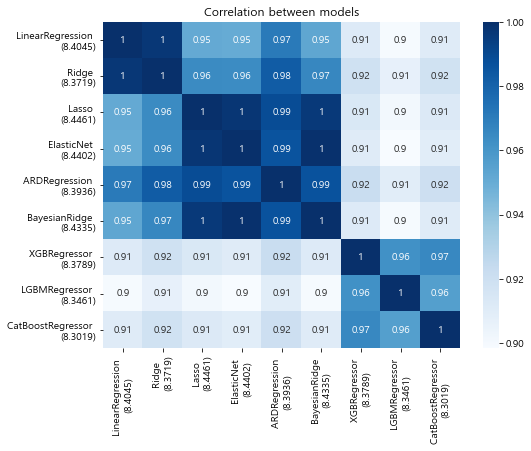

In [ ]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = list(clf.predict(x_dev))
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)
ensemble_results = ensemble_results.applymap(lambda x: float(x))

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

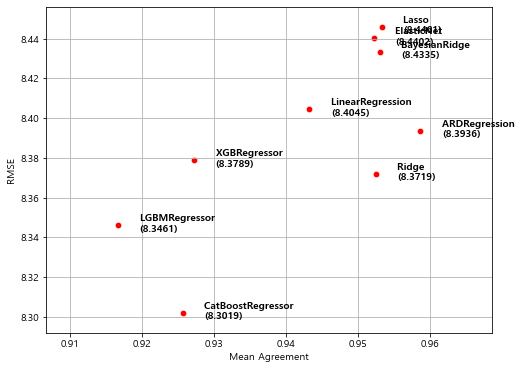

In [ ]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
rmse = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'rmse': rmse, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="rmse", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.rmse[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.rmse.min()-0.01,df.rmse.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [ ]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
#             'XGBRegressor',
            'LGBMRegressor',
            'CatBoostRegressor'
            ]
models_for_ensemble = [(name,clf) for name,clf,score in clfs_tuned if name in selected]
avg_reg = VotingRegressor(estimators=models_for_ensemble)
avg_reg.fit(x_train,y_train)
score = mean_squared_error(avg_reg.predict(x_dev), y_dev, squared=False)
print(score)
pd.DataFrame({'custid': test_id, 'age': avg_reg.predict(x_test)}).to_csv('averaging_rid_lgbm_cat.csv', index=False)

Learning rate set to 0.063286
0:	learn: 10.2714428	total: 144ms	remaining: 2m 23s
1:	learn: 10.1274113	total: 261ms	remaining: 2m 10s
2:	learn: 9.9935588	total: 428ms	remaining: 2m 22s
3:	learn: 9.8746278	total: 570ms	remaining: 2m 21s
4:	learn: 9.7679042	total: 705ms	remaining: 2m 20s
5:	learn: 9.6608020	total: 878ms	remaining: 2m 25s
6:	learn: 9.5683920	total: 1.01s	remaining: 2m 23s
7:	learn: 9.4807077	total: 1.13s	remaining: 2m 19s
8:	learn: 9.4090495	total: 1.24s	remaining: 2m 16s
9:	learn: 9.3378620	total: 1.39s	remaining: 2m 17s
10:	learn: 9.2762094	total: 1.59s	remaining: 2m 23s
11:	learn: 9.2162889	total: 1.78s	remaining: 2m 27s
12:	learn: 9.1664835	total: 1.93s	remaining: 2m 26s
13:	learn: 9.1120753	total: 2.07s	remaining: 2m 25s
14:	learn: 9.0647561	total: 2.19s	remaining: 2m 23s
15:	learn: 9.0237105	total: 2.31s	remaining: 2m 22s
16:	learn: 8.9854952	total: 2.42s	remaining: 2m 19s
17:	learn: 8.9419561	total: 2.54s	remaining: 2m 18s
18:	learn: 8.9043288	total: 2.65s	remainin

160:	learn: 7.7993606	total: 21s	remaining: 1m 49s
161:	learn: 7.7949477	total: 21.1s	remaining: 1m 49s
162:	learn: 7.7891018	total: 21.2s	remaining: 1m 49s
163:	learn: 7.7839388	total: 21.4s	remaining: 1m 48s
164:	learn: 7.7784484	total: 21.5s	remaining: 1m 48s
165:	learn: 7.7747313	total: 21.6s	remaining: 1m 48s
166:	learn: 7.7702431	total: 21.7s	remaining: 1m 48s
167:	learn: 7.7667484	total: 21.9s	remaining: 1m 48s
168:	learn: 7.7616221	total: 22s	remaining: 1m 48s
169:	learn: 7.7577508	total: 22.1s	remaining: 1m 48s
170:	learn: 7.7530052	total: 22.3s	remaining: 1m 47s
171:	learn: 7.7479222	total: 22.4s	remaining: 1m 47s
172:	learn: 7.7439204	total: 22.5s	remaining: 1m 47s
173:	learn: 7.7397000	total: 22.6s	remaining: 1m 47s
174:	learn: 7.7348459	total: 22.7s	remaining: 1m 47s
175:	learn: 7.7311152	total: 22.9s	remaining: 1m 47s
176:	learn: 7.7265295	total: 23s	remaining: 1m 46s
177:	learn: 7.7220254	total: 23.1s	remaining: 1m 46s
178:	learn: 7.7181241	total: 23.2s	remaining: 1m 46s

317:	learn: 7.1131894	total: 39.6s	remaining: 1m 24s
318:	learn: 7.1094419	total: 39.7s	remaining: 1m 24s
319:	learn: 7.1048714	total: 39.8s	remaining: 1m 24s
320:	learn: 7.1015512	total: 39.9s	remaining: 1m 24s
321:	learn: 7.0982055	total: 40s	remaining: 1m 24s
322:	learn: 7.0938472	total: 40.1s	remaining: 1m 24s
323:	learn: 7.0907343	total: 40.3s	remaining: 1m 23s
324:	learn: 7.0880028	total: 40.4s	remaining: 1m 23s
325:	learn: 7.0831055	total: 40.5s	remaining: 1m 23s
326:	learn: 7.0781253	total: 40.6s	remaining: 1m 23s
327:	learn: 7.0756826	total: 40.7s	remaining: 1m 23s
328:	learn: 7.0710638	total: 40.8s	remaining: 1m 23s
329:	learn: 7.0690569	total: 40.9s	remaining: 1m 23s
330:	learn: 7.0645366	total: 41s	remaining: 1m 22s
331:	learn: 7.0608108	total: 41.1s	remaining: 1m 22s
332:	learn: 7.0556433	total: 41.3s	remaining: 1m 22s
333:	learn: 7.0523434	total: 41.4s	remaining: 1m 22s
334:	learn: 7.0485377	total: 41.5s	remaining: 1m 22s
335:	learn: 7.0439533	total: 41.6s	remaining: 1m 2

473:	learn: 6.5524229	total: 57s	remaining: 1m 3s
474:	learn: 6.5495811	total: 57.2s	remaining: 1m 3s
475:	learn: 6.5450752	total: 57.3s	remaining: 1m 3s
476:	learn: 6.5415656	total: 57.4s	remaining: 1m 2s
477:	learn: 6.5381963	total: 57.6s	remaining: 1m 2s
478:	learn: 6.5347280	total: 57.7s	remaining: 1m 2s
479:	learn: 6.5315143	total: 57.8s	remaining: 1m 2s
480:	learn: 6.5276932	total: 58s	remaining: 1m 2s
481:	learn: 6.5241258	total: 58.1s	remaining: 1m 2s
482:	learn: 6.5207630	total: 58.2s	remaining: 1m 2s
483:	learn: 6.5174352	total: 58.3s	remaining: 1m 2s
484:	learn: 6.5151154	total: 58.4s	remaining: 1m 2s
485:	learn: 6.5114504	total: 58.5s	remaining: 1m 1s
486:	learn: 6.5079135	total: 58.6s	remaining: 1m 1s
487:	learn: 6.5044077	total: 58.7s	remaining: 1m 1s
488:	learn: 6.5004935	total: 58.9s	remaining: 1m 1s
489:	learn: 6.4974176	total: 59s	remaining: 1m 1s
490:	learn: 6.4934130	total: 59.1s	remaining: 1m 1s
491:	learn: 6.4900242	total: 59.2s	remaining: 1m 1s
492:	learn: 6.4860

633:	learn: 6.0398285	total: 1m 14s	remaining: 42.8s
634:	learn: 6.0368047	total: 1m 14s	remaining: 42.7s
635:	learn: 6.0327287	total: 1m 14s	remaining: 42.6s
636:	learn: 6.0296337	total: 1m 14s	remaining: 42.5s
637:	learn: 6.0265664	total: 1m 14s	remaining: 42.3s
638:	learn: 6.0228524	total: 1m 14s	remaining: 42.2s
639:	learn: 6.0190182	total: 1m 14s	remaining: 42.1s
640:	learn: 6.0151464	total: 1m 14s	remaining: 42s
641:	learn: 6.0121896	total: 1m 15s	remaining: 41.9s
642:	learn: 6.0091445	total: 1m 15s	remaining: 41.7s
643:	learn: 6.0062744	total: 1m 15s	remaining: 41.6s
644:	learn: 6.0041298	total: 1m 15s	remaining: 41.5s
645:	learn: 5.9994509	total: 1m 15s	remaining: 41.4s
646:	learn: 5.9964330	total: 1m 15s	remaining: 41.3s
647:	learn: 5.9939379	total: 1m 15s	remaining: 41.2s
648:	learn: 5.9905661	total: 1m 15s	remaining: 41.1s
649:	learn: 5.9876094	total: 1m 16s	remaining: 40.9s
650:	learn: 5.9846215	total: 1m 16s	remaining: 40.8s
651:	learn: 5.9819361	total: 1m 16s	remaining: 4

789:	learn: 5.5971338	total: 1m 30s	remaining: 24.1s
790:	learn: 5.5947651	total: 1m 30s	remaining: 23.9s
791:	learn: 5.5916210	total: 1m 30s	remaining: 23.8s
792:	learn: 5.5892993	total: 1m 30s	remaining: 23.7s
793:	learn: 5.5868842	total: 1m 30s	remaining: 23.6s
794:	learn: 5.5841772	total: 1m 31s	remaining: 23.5s
795:	learn: 5.5815178	total: 1m 31s	remaining: 23.4s
796:	learn: 5.5783828	total: 1m 31s	remaining: 23.2s
797:	learn: 5.5755532	total: 1m 31s	remaining: 23.1s
798:	learn: 5.5737133	total: 1m 31s	remaining: 23s
799:	learn: 5.5713137	total: 1m 31s	remaining: 22.9s
800:	learn: 5.5687379	total: 1m 31s	remaining: 22.8s
801:	learn: 5.5671260	total: 1m 31s	remaining: 22.6s
802:	learn: 5.5642480	total: 1m 31s	remaining: 22.5s
803:	learn: 5.5625274	total: 1m 31s	remaining: 22.4s
804:	learn: 5.5600119	total: 1m 32s	remaining: 22.3s
805:	learn: 5.5564656	total: 1m 32s	remaining: 22.2s
806:	learn: 5.5538339	total: 1m 32s	remaining: 22.1s
807:	learn: 5.5512427	total: 1m 32s	remaining: 2

945:	learn: 5.2021853	total: 1m 46s	remaining: 6.06s
946:	learn: 5.2003336	total: 1m 46s	remaining: 5.95s
947:	learn: 5.1974370	total: 1m 46s	remaining: 5.84s
948:	learn: 5.1945543	total: 1m 46s	remaining: 5.72s
949:	learn: 5.1925654	total: 1m 46s	remaining: 5.61s
950:	learn: 5.1905013	total: 1m 46s	remaining: 5.5s
951:	learn: 5.1878493	total: 1m 46s	remaining: 5.39s
952:	learn: 5.1848837	total: 1m 46s	remaining: 5.27s
953:	learn: 5.1821484	total: 1m 47s	remaining: 5.16s
954:	learn: 5.1795304	total: 1m 47s	remaining: 5.05s
955:	learn: 5.1761482	total: 1m 47s	remaining: 4.94s
956:	learn: 5.1738905	total: 1m 47s	remaining: 4.82s
957:	learn: 5.1703087	total: 1m 47s	remaining: 4.71s
958:	learn: 5.1681201	total: 1m 47s	remaining: 4.6s
959:	learn: 5.1658236	total: 1m 47s	remaining: 4.49s
960:	learn: 5.1629787	total: 1m 47s	remaining: 4.37s
961:	learn: 5.1600478	total: 1m 47s	remaining: 4.26s
962:	learn: 5.1572362	total: 1m 47s	remaining: 4.15s
963:	learn: 5.1551486	total: 1m 48s	remaining: 4

In [ ]:
8.245049744129629 
8.242384614765621
8.239661654729673
8.220307683303453
8.21609175457467

In [ ]:
model = []
for name, clf, score in clfs_tuned:
    model.append(clf.best_estimator_)

In [ ]:
# model = []
# for name, clf, score in clfs_tuned:
#     model.append(clf.best_estimator_)
train_x_all, train_y_all = x_train.copy(), y_train.copy()
models = []
# model_Linear = model[0]
# model_Linear.fit(x_train, y_train)
# train_Linear = model_Linear.predict(x_dev)
# models.append(model_Linear)

model_Ridge = model[1]
model_Ridge.fit(x_train, y_train)
train_Ridge = model_Ridge.predict(x_dev)
models.append(model_Ridge)


# model_Lasso = model[2]
# model_Lasso.fit(x_train, y_train)
# train_Lasso = model_Lasso.predict(x_dev)
# models.append(model_Lasso)


# model_ENet = model[3]
# model_ENet.fit(x_train, y_train)
# train_ENet = model_ENet.predict(x_dev)
# models.append(model_ENet)


# model_ARD = model[4]
# model_ARD.fit(x_train, y_train)
# train_ARD = model_ARD.predict(x_dev)
# models.append(model_ARD)


# model_Bayesian = model[5]
# model_Bayesian.fit(x_train, y_train)
# train_Bayesian = model_Bayesian.predict(x_dev)
# models.append(model_Bayesian)


model_XGB = model[6]
model_XGB.fit(x_train, y_train, verbose=False)
train_XGB = model_XGB.predict(x_dev)
models.append(model_XGB)


# model_LGBM = model[7]
# model_LGBM.fit(x_train, y_train, verbose=False)
# train_LGBM = model_LGBM.predict(x_dev)
# models.append(model_LGBM)


model_Cat = model[8]
model_Cat.fit(x_train, y_train, verbose=False)
train_Cat = model_Cat.predict(x_dev)
models.append(model_Cat)

In [ ]:
weights = []
rmse_best = 1000
for i in range(1, 10, 1):
    for j in range(1, 10, 1):
        for k in range(1, 10, 1):
            if (i+j+k) != 10:
                continue
            pred = (models[0].predict(x_dev).flatten() * i + models[1].predict(x_dev) * j + models[2].predict(x_dev) * k)/10
            rmse = mean_squared_error(pred, y_dev, squared=False)
            print(rmse, i,j,k)            
            if rmse < rmse_best:
                weights = [i,j,k]
                rmse_best = rmse 
print(rmse_best, weights)

8.291367235275567 1 1 8
8.289260687982882 1 2 7
8.29062790625486 1 3 6
8.295467173634279 1 4 5
8.303772422901496 1 5 4
8.315533255721284 1 6 3
8.33073505248641 1 7 2
8.349359011132455 1 8 1
8.273099760934297 2 1 7
8.272853353436348 2 2 6
8.276087346239962 2 3 5
8.28279766400688 2 4 4
8.292975870889942 2 5 3
8.306609205809202 2 6 2
8.323680707356443 2 7 1
8.263152693564994 3 1 6
8.264772605475422 3 2 5
8.269875222991216 3 3 4
8.278454107835662 3 4 3
8.290498470997722 3 5 2
8.30599322343157 3 6 1
8.261556086997118 4 1 5
8.265042866894303 4 2 4
8.272010300025274 4 3 3
8.282449604243537 4 4 2
8.296347675856994 4 5 1
8.268314778638828 5 1 4
8.273663319329183 5 2 3
8.282486122067082 5 3 2
8.29477210276184 5 4 1
8.283408316468819 6 1 3
8.290607915602775 6 2 2
8.301271112267859 6 3 1
8.306791267069476 7 1 2
8.315825771234449 7 2 1
8.338393893946728 8 1 1
8.261556086997118 [4, 1, 5]


In [ ]:
for i, m in enumerate(models):
    m.fit(train_x_all, train_y_all)
    models[i] = m

Learning rate set to 0.063286
0:	learn: 10.2778415	total: 59.9ms	remaining: 59.9s
1:	learn: 10.1340462	total: 110ms	remaining: 54.7s
2:	learn: 9.9972770	total: 160ms	remaining: 53.2s
3:	learn: 9.8828176	total: 210ms	remaining: 52.4s
4:	learn: 9.7771978	total: 265ms	remaining: 52.8s
5:	learn: 9.6784021	total: 318ms	remaining: 52.7s
6:	learn: 9.5966197	total: 375ms	remaining: 53.2s
7:	learn: 9.5064136	total: 432ms	remaining: 53.5s
8:	learn: 9.4185658	total: 497ms	remaining: 54.7s
9:	learn: 9.3476918	total: 555ms	remaining: 54.9s
10:	learn: 9.2909376	total: 614ms	remaining: 55.2s
11:	learn: 9.2344049	total: 677ms	remaining: 55.8s
12:	learn: 9.1798625	total: 733ms	remaining: 55.7s
13:	learn: 9.1204537	total: 797ms	remaining: 56.2s
14:	learn: 9.0728688	total: 883ms	remaining: 58s
15:	learn: 9.0268948	total: 962ms	remaining: 59.1s
16:	learn: 8.9835633	total: 1.03s	remaining: 59.9s
17:	learn: 8.9468507	total: 1.12s	remaining: 1m 1s
18:	learn: 8.9148697	total: 1.19s	remaining: 1m 1s
19:	learn:

162:	learn: 7.8276244	total: 9.78s	remaining: 50.2s
163:	learn: 7.8237076	total: 9.83s	remaining: 50.1s
164:	learn: 7.8195249	total: 9.87s	remaining: 50s
165:	learn: 7.8162429	total: 9.92s	remaining: 49.8s
166:	learn: 7.8098665	total: 9.98s	remaining: 49.8s
167:	learn: 7.8054320	total: 10s	remaining: 49.7s
168:	learn: 7.8015839	total: 10.1s	remaining: 49.5s
169:	learn: 7.7961256	total: 10.1s	remaining: 49.4s
170:	learn: 7.7912649	total: 10.2s	remaining: 49.3s
171:	learn: 7.7873045	total: 10.2s	remaining: 49.2s
172:	learn: 7.7838434	total: 10.3s	remaining: 49s
173:	learn: 7.7798753	total: 10.3s	remaining: 48.9s
174:	learn: 7.7752380	total: 10.3s	remaining: 48.8s
175:	learn: 7.7701494	total: 10.4s	remaining: 48.7s
176:	learn: 7.7645664	total: 10.4s	remaining: 48.6s
177:	learn: 7.7590040	total: 10.5s	remaining: 48.4s
178:	learn: 7.7528294	total: 10.5s	remaining: 48.3s
179:	learn: 7.7486477	total: 10.6s	remaining: 48.2s
180:	learn: 7.7429940	total: 10.6s	remaining: 48.1s
181:	learn: 7.7385

324:	learn: 7.1409639	total: 18.1s	remaining: 37.5s
325:	learn: 7.1366360	total: 18.1s	remaining: 37.5s
326:	learn: 7.1335943	total: 18.2s	remaining: 37.4s
327:	learn: 7.1299676	total: 18.2s	remaining: 37.4s
328:	learn: 7.1267939	total: 18.3s	remaining: 37.3s
329:	learn: 7.1224438	total: 18.3s	remaining: 37.2s
330:	learn: 7.1180312	total: 18.4s	remaining: 37.1s
331:	learn: 7.1142803	total: 18.4s	remaining: 37.1s
332:	learn: 7.1095150	total: 18.5s	remaining: 37s
333:	learn: 7.1069637	total: 18.5s	remaining: 37s
334:	learn: 7.1035607	total: 18.6s	remaining: 36.9s
335:	learn: 7.1001253	total: 18.7s	remaining: 36.9s
336:	learn: 7.0966781	total: 18.7s	remaining: 36.9s
337:	learn: 7.0930380	total: 18.8s	remaining: 36.8s
338:	learn: 7.0888784	total: 18.9s	remaining: 36.9s
339:	learn: 7.0858053	total: 18.9s	remaining: 36.8s
340:	learn: 7.0817355	total: 19s	remaining: 36.7s
341:	learn: 7.0787969	total: 19s	remaining: 36.6s
342:	learn: 7.0761943	total: 19.1s	remaining: 36.6s
343:	learn: 7.071802

485:	learn: 6.5961149	total: 26.9s	remaining: 28.5s
486:	learn: 6.5933427	total: 27s	remaining: 28.4s
487:	learn: 6.5907996	total: 27s	remaining: 28.4s
488:	learn: 6.5880549	total: 27.1s	remaining: 28.3s
489:	learn: 6.5849598	total: 27.2s	remaining: 28.3s
490:	learn: 6.5828786	total: 27.2s	remaining: 28.2s
491:	learn: 6.5813854	total: 27.3s	remaining: 28.1s
492:	learn: 6.5783591	total: 27.3s	remaining: 28.1s
493:	learn: 6.5744422	total: 27.3s	remaining: 28s
494:	learn: 6.5712585	total: 27.4s	remaining: 27.9s
495:	learn: 6.5682422	total: 27.4s	remaining: 27.9s
496:	learn: 6.5641778	total: 27.5s	remaining: 27.8s
497:	learn: 6.5614416	total: 27.5s	remaining: 27.8s
498:	learn: 6.5572453	total: 27.6s	remaining: 27.7s
499:	learn: 6.5548713	total: 27.6s	remaining: 27.6s
500:	learn: 6.5522665	total: 27.7s	remaining: 27.6s
501:	learn: 6.5478385	total: 27.7s	remaining: 27.5s
502:	learn: 6.5448499	total: 27.8s	remaining: 27.5s
503:	learn: 6.5415837	total: 27.8s	remaining: 27.4s
504:	learn: 6.5394

647:	learn: 6.1205573	total: 35.6s	remaining: 19.3s
648:	learn: 6.1177544	total: 35.6s	remaining: 19.3s
649:	learn: 6.1148034	total: 35.7s	remaining: 19.2s
650:	learn: 6.1126329	total: 35.7s	remaining: 19.2s
651:	learn: 6.1104491	total: 35.8s	remaining: 19.1s
652:	learn: 6.1075250	total: 35.9s	remaining: 19.1s
653:	learn: 6.1038595	total: 35.9s	remaining: 19s
654:	learn: 6.1003915	total: 36s	remaining: 18.9s
655:	learn: 6.0982773	total: 36s	remaining: 18.9s
656:	learn: 6.0952462	total: 36s	remaining: 18.8s
657:	learn: 6.0934171	total: 36.1s	remaining: 18.8s
658:	learn: 6.0913892	total: 36.1s	remaining: 18.7s
659:	learn: 6.0878248	total: 36.2s	remaining: 18.6s
660:	learn: 6.0849238	total: 36.2s	remaining: 18.6s
661:	learn: 6.0819167	total: 36.3s	remaining: 18.5s
662:	learn: 6.0793614	total: 36.3s	remaining: 18.5s
663:	learn: 6.0766430	total: 36.4s	remaining: 18.4s
664:	learn: 6.0747317	total: 36.4s	remaining: 18.4s
665:	learn: 6.0712548	total: 36.5s	remaining: 18.3s
666:	learn: 6.068903

808:	learn: 5.7001603	total: 43.9s	remaining: 10.4s
809:	learn: 5.6965954	total: 44s	remaining: 10.3s
810:	learn: 5.6936981	total: 44s	remaining: 10.3s
811:	learn: 5.6911097	total: 44.1s	remaining: 10.2s
812:	learn: 5.6893735	total: 44.1s	remaining: 10.2s
813:	learn: 5.6877087	total: 44.2s	remaining: 10.1s
814:	learn: 5.6855334	total: 44.2s	remaining: 10s
815:	learn: 5.6827578	total: 44.3s	remaining: 9.99s
816:	learn: 5.6798751	total: 44.3s	remaining: 9.93s
817:	learn: 5.6772813	total: 44.4s	remaining: 9.88s
818:	learn: 5.6738957	total: 44.4s	remaining: 9.82s
819:	learn: 5.6712115	total: 44.5s	remaining: 9.77s
820:	learn: 5.6691456	total: 44.5s	remaining: 9.71s
821:	learn: 5.6674029	total: 44.6s	remaining: 9.66s
822:	learn: 5.6659717	total: 44.6s	remaining: 9.6s
823:	learn: 5.6626691	total: 44.7s	remaining: 9.54s
824:	learn: 5.6599697	total: 44.7s	remaining: 9.49s
825:	learn: 5.6577051	total: 44.8s	remaining: 9.44s
826:	learn: 5.6548646	total: 44.8s	remaining: 9.38s
827:	learn: 5.65345

968:	learn: 5.3300190	total: 51.9s	remaining: 1.66s
969:	learn: 5.3274922	total: 52s	remaining: 1.61s
970:	learn: 5.3246067	total: 52.1s	remaining: 1.55s
971:	learn: 5.3220272	total: 52.1s	remaining: 1.5s
972:	learn: 5.3198687	total: 52.1s	remaining: 1.45s
973:	learn: 5.3172171	total: 52.2s	remaining: 1.39s
974:	learn: 5.3148373	total: 52.3s	remaining: 1.34s
975:	learn: 5.3122941	total: 52.3s	remaining: 1.29s
976:	learn: 5.3093218	total: 52.4s	remaining: 1.23s
977:	learn: 5.3071981	total: 52.4s	remaining: 1.18s
978:	learn: 5.3045567	total: 52.5s	remaining: 1.13s
979:	learn: 5.3017454	total: 52.5s	remaining: 1.07s
980:	learn: 5.2993468	total: 52.6s	remaining: 1.02s
981:	learn: 5.2967745	total: 52.6s	remaining: 964ms
982:	learn: 5.2940692	total: 52.7s	remaining: 911ms
983:	learn: 5.2905129	total: 52.7s	remaining: 857ms
984:	learn: 5.2877107	total: 52.8s	remaining: 803ms
985:	learn: 5.2846443	total: 52.8s	remaining: 750ms
986:	learn: 5.2817453	total: 52.9s	remaining: 696ms
987:	learn: 5.2

In [ ]:
pred = (models[0].predict(x_test).flatten() * weights[0] + models[1].predict(x_test) * weights[1] + models[2].predict(x_test) * weights[2])/10
t = pd.Timestamp.now()
fname = f"submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="custid"), pd.Series(pred, name="age")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'submission_0606_2220.csv' is ready to submit.


In [ ]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            'LGBMRegressor',
            'CatBoostRegressor'
            ]
models_for_ensemble = [(name,clf) for name,clf,score in clfs_tuned if name in selected]
avg_reg = VotingRegressor(estimators=models_for_ensemble)
avg_reg.fit(x_train2,y_train2)
score = mean_squared_error(avg_reg.predict(x_dev), y_dev, squared=False)
score

Learning rate set to 0.063286
0:	learn: 10.2796317	total: 35.2ms	remaining: 35.1s
1:	learn: 10.1389238	total: 75.4ms	remaining: 37.6s
2:	learn: 10.0023814	total: 114ms	remaining: 37.8s
3:	learn: 9.8884929	total: 153ms	remaining: 38s
4:	learn: 9.7763435	total: 192ms	remaining: 38.2s
5:	learn: 9.6713732	total: 240ms	remaining: 39.7s
6:	learn: 9.5867433	total: 305ms	remaining: 43.2s
7:	learn: 9.5047967	total: 345ms	remaining: 42.8s
8:	learn: 9.4253759	total: 385ms	remaining: 42.4s
9:	learn: 9.3514602	total: 431ms	remaining: 42.6s
10:	learn: 9.2813580	total: 470ms	remaining: 42.3s
11:	learn: 9.2198138	total: 511ms	remaining: 42.1s
12:	learn: 9.1621526	total: 551ms	remaining: 41.9s
13:	learn: 9.1161530	total: 603ms	remaining: 42.5s
14:	learn: 9.0694322	total: 666ms	remaining: 43.8s
15:	learn: 9.0267256	total: 707ms	remaining: 43.5s
16:	learn: 8.9823430	total: 747ms	remaining: 43.2s
17:	learn: 8.9439624	total: 787ms	remaining: 42.9s
18:	learn: 8.9093687	total: 836ms	remaining: 43.2s
19:	lear

161:	learn: 7.8304708	total: 8.01s	remaining: 41.5s
162:	learn: 7.8253800	total: 8.07s	remaining: 41.5s
163:	learn: 7.8208349	total: 8.13s	remaining: 41.4s
164:	learn: 7.8166578	total: 8.17s	remaining: 41.4s
165:	learn: 7.8127367	total: 8.23s	remaining: 41.4s
166:	learn: 7.8094204	total: 8.28s	remaining: 41.3s
167:	learn: 7.8043434	total: 8.33s	remaining: 41.3s
168:	learn: 7.7999331	total: 8.38s	remaining: 41.2s
169:	learn: 7.7950047	total: 8.43s	remaining: 41.1s
170:	learn: 7.7902444	total: 8.48s	remaining: 41.1s
171:	learn: 7.7864793	total: 8.53s	remaining: 41.1s
172:	learn: 7.7809921	total: 8.58s	remaining: 41s
173:	learn: 7.7767597	total: 8.63s	remaining: 41s
174:	learn: 7.7707638	total: 8.68s	remaining: 40.9s
175:	learn: 7.7667162	total: 8.73s	remaining: 40.9s
176:	learn: 7.7612527	total: 8.79s	remaining: 40.9s
177:	learn: 7.7582631	total: 8.83s	remaining: 40.8s
178:	learn: 7.7526525	total: 8.88s	remaining: 40.7s
179:	learn: 7.7477792	total: 8.93s	remaining: 40.7s
180:	learn: 7.74

324:	learn: 7.1401668	total: 15.9s	remaining: 33.1s
325:	learn: 7.1370386	total: 16s	remaining: 33.1s
326:	learn: 7.1334548	total: 16s	remaining: 33s
327:	learn: 7.1289177	total: 16.1s	remaining: 32.9s
328:	learn: 7.1264665	total: 16.1s	remaining: 32.9s
329:	learn: 7.1225046	total: 16.2s	remaining: 32.8s
330:	learn: 7.1189851	total: 16.2s	remaining: 32.8s
331:	learn: 7.1162702	total: 16.3s	remaining: 32.7s
332:	learn: 7.1134796	total: 16.3s	remaining: 32.7s
333:	learn: 7.1107305	total: 16.4s	remaining: 32.6s
334:	learn: 7.1070606	total: 16.4s	remaining: 32.6s
335:	learn: 7.1035081	total: 16.4s	remaining: 32.5s
336:	learn: 7.0997250	total: 16.5s	remaining: 32.5s
337:	learn: 7.0964025	total: 16.5s	remaining: 32.4s
338:	learn: 7.0918500	total: 16.6s	remaining: 32.3s
339:	learn: 7.0882211	total: 16.6s	remaining: 32.3s
340:	learn: 7.0853441	total: 16.7s	remaining: 32.3s
341:	learn: 7.0823518	total: 16.7s	remaining: 32.2s
342:	learn: 7.0782738	total: 16.8s	remaining: 32.1s
343:	learn: 7.0749

483:	learn: 6.6071058	total: 23.3s	remaining: 24.9s
484:	learn: 6.6032541	total: 23.4s	remaining: 24.8s
485:	learn: 6.6002668	total: 23.4s	remaining: 24.7s
486:	learn: 6.5983972	total: 23.4s	remaining: 24.7s
487:	learn: 6.5961479	total: 23.5s	remaining: 24.6s
488:	learn: 6.5943462	total: 23.5s	remaining: 24.6s
489:	learn: 6.5904549	total: 23.6s	remaining: 24.6s
490:	learn: 6.5880174	total: 23.6s	remaining: 24.5s
491:	learn: 6.5851988	total: 23.7s	remaining: 24.4s
492:	learn: 6.5816625	total: 23.7s	remaining: 24.4s
493:	learn: 6.5778971	total: 23.8s	remaining: 24.4s
494:	learn: 6.5746163	total: 23.8s	remaining: 24.3s
495:	learn: 6.5712568	total: 23.9s	remaining: 24.3s
496:	learn: 6.5692176	total: 23.9s	remaining: 24.2s
497:	learn: 6.5664412	total: 24s	remaining: 24.2s
498:	learn: 6.5643546	total: 24s	remaining: 24.1s
499:	learn: 6.5607294	total: 24.1s	remaining: 24.1s
500:	learn: 6.5575218	total: 24.1s	remaining: 24s
501:	learn: 6.5554514	total: 24.2s	remaining: 24s
502:	learn: 6.552132

643:	learn: 6.1378883	total: 30.8s	remaining: 17s
644:	learn: 6.1350944	total: 30.9s	remaining: 17s
645:	learn: 6.1323743	total: 30.9s	remaining: 16.9s
646:	learn: 6.1294598	total: 31s	remaining: 16.9s
647:	learn: 6.1272979	total: 31s	remaining: 16.9s
648:	learn: 6.1247277	total: 31.1s	remaining: 16.8s
649:	learn: 6.1224669	total: 31.1s	remaining: 16.8s
650:	learn: 6.1191723	total: 31.2s	remaining: 16.7s
651:	learn: 6.1172083	total: 31.2s	remaining: 16.7s
652:	learn: 6.1138744	total: 31.3s	remaining: 16.6s
653:	learn: 6.1111479	total: 31.3s	remaining: 16.6s
654:	learn: 6.1084223	total: 31.3s	remaining: 16.5s
655:	learn: 6.1040910	total: 31.4s	remaining: 16.5s
656:	learn: 6.1012282	total: 31.4s	remaining: 16.4s
657:	learn: 6.0983184	total: 31.5s	remaining: 16.4s
658:	learn: 6.0956802	total: 31.5s	remaining: 16.3s
659:	learn: 6.0920626	total: 31.6s	remaining: 16.3s
660:	learn: 6.0893954	total: 31.6s	remaining: 16.2s
661:	learn: 6.0860537	total: 31.7s	remaining: 16.2s
662:	learn: 6.084388

802:	learn: 5.7111328	total: 38.2s	remaining: 9.37s
803:	learn: 5.7090199	total: 38.2s	remaining: 9.32s
804:	learn: 5.7062005	total: 38.3s	remaining: 9.27s
805:	learn: 5.7031508	total: 38.3s	remaining: 9.22s
806:	learn: 5.7008032	total: 38.4s	remaining: 9.18s
807:	learn: 5.6983860	total: 38.4s	remaining: 9.13s
808:	learn: 5.6950352	total: 38.5s	remaining: 9.08s
809:	learn: 5.6925509	total: 38.5s	remaining: 9.03s
810:	learn: 5.6898275	total: 38.6s	remaining: 8.99s
811:	learn: 5.6869733	total: 38.6s	remaining: 8.94s
812:	learn: 5.6837850	total: 38.6s	remaining: 8.89s
813:	learn: 5.6808069	total: 38.7s	remaining: 8.84s
814:	learn: 5.6786870	total: 38.7s	remaining: 8.79s
815:	learn: 5.6768953	total: 38.8s	remaining: 8.74s
816:	learn: 5.6740852	total: 38.8s	remaining: 8.7s
817:	learn: 5.6711850	total: 38.9s	remaining: 8.65s
818:	learn: 5.6685238	total: 38.9s	remaining: 8.6s
819:	learn: 5.6657028	total: 39s	remaining: 8.55s
820:	learn: 5.6634535	total: 39s	remaining: 8.5s
821:	learn: 5.66109

962:	learn: 5.3379309	total: 45.4s	remaining: 1.74s
963:	learn: 5.3356690	total: 45.4s	remaining: 1.7s
964:	learn: 5.3327190	total: 45.5s	remaining: 1.65s
965:	learn: 5.3309762	total: 45.5s	remaining: 1.6s
966:	learn: 5.3279121	total: 45.6s	remaining: 1.55s
967:	learn: 5.3257733	total: 45.6s	remaining: 1.51s
968:	learn: 5.3244594	total: 45.7s	remaining: 1.46s
969:	learn: 5.3220042	total: 45.7s	remaining: 1.41s
970:	learn: 5.3210693	total: 45.7s	remaining: 1.36s
971:	learn: 5.3185489	total: 45.8s	remaining: 1.32s
972:	learn: 5.3160639	total: 45.8s	remaining: 1.27s
973:	learn: 5.3139592	total: 45.9s	remaining: 1.22s
974:	learn: 5.3114872	total: 45.9s	remaining: 1.18s
975:	learn: 5.3093481	total: 46s	remaining: 1.13s
976:	learn: 5.3064119	total: 46s	remaining: 1.08s
977:	learn: 5.3047775	total: 46s	remaining: 1.03s
978:	learn: 5.3030557	total: 46.1s	remaining: 989ms
979:	learn: 5.3010912	total: 46.1s	remaining: 941ms
980:	learn: 5.2984351	total: 46.2s	remaining: 894ms
981:	learn: 5.296555

8.272755819261087

In [ ]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            #'LGBMRegressor',
            'CatBoostRegressor'
            ]
models_for_ensemble = [(name,clf) for name,clf,score in clfs_tuned if name in selected]
avg_reg = VotingRegressor(estimators=models_for_ensemble)
avg_reg.fit(x_train2,y_train2)
score = mean_squared_error(avg_reg.predict(x_dev), y_dev, squared=False)
score

Learning rate set to 0.063286
0:	learn: 10.2796317	total: 39.1ms	remaining: 39.1s
1:	learn: 10.1389238	total: 94.2ms	remaining: 47s
2:	learn: 10.0023814	total: 142ms	remaining: 47.3s
3:	learn: 9.8884929	total: 197ms	remaining: 49s
4:	learn: 9.7763435	total: 259ms	remaining: 51.5s
5:	learn: 9.6713732	total: 337ms	remaining: 55.7s
6:	learn: 9.5867433	total: 383ms	remaining: 54.3s
7:	learn: 9.5047967	total: 431ms	remaining: 53.5s
8:	learn: 9.4253759	total: 482ms	remaining: 53.1s
9:	learn: 9.3514602	total: 534ms	remaining: 52.9s
10:	learn: 9.2813580	total: 587ms	remaining: 52.8s
11:	learn: 9.2198138	total: 635ms	remaining: 52.3s
12:	learn: 9.1621526	total: 689ms	remaining: 52.3s
13:	learn: 9.1161530	total: 750ms	remaining: 52.8s
14:	learn: 9.0694322	total: 811ms	remaining: 53.2s
15:	learn: 9.0267256	total: 872ms	remaining: 53.6s
16:	learn: 8.9823430	total: 930ms	remaining: 53.8s
17:	learn: 8.9439624	total: 996ms	remaining: 54.3s
18:	learn: 8.9093687	total: 1.07s	remaining: 55.1s
19:	learn:

161:	learn: 7.8304708	total: 8.35s	remaining: 43.2s
162:	learn: 7.8253800	total: 8.39s	remaining: 43.1s
163:	learn: 7.8208349	total: 8.45s	remaining: 43.1s
164:	learn: 7.8166578	total: 8.5s	remaining: 43s
165:	learn: 7.8127367	total: 8.54s	remaining: 42.9s
166:	learn: 7.8094204	total: 8.59s	remaining: 42.9s
167:	learn: 7.8043434	total: 8.64s	remaining: 42.8s
168:	learn: 7.7999331	total: 8.68s	remaining: 42.7s
169:	learn: 7.7950047	total: 8.72s	remaining: 42.6s
170:	learn: 7.7902444	total: 8.77s	remaining: 42.5s
171:	learn: 7.7864793	total: 8.81s	remaining: 42.4s
172:	learn: 7.7809921	total: 8.86s	remaining: 42.4s
173:	learn: 7.7767597	total: 8.9s	remaining: 42.3s
174:	learn: 7.7707638	total: 8.95s	remaining: 42.2s
175:	learn: 7.7667162	total: 9s	remaining: 42.1s
176:	learn: 7.7612527	total: 9.04s	remaining: 42.1s
177:	learn: 7.7582631	total: 9.1s	remaining: 42s
178:	learn: 7.7526525	total: 9.14s	remaining: 41.9s
179:	learn: 7.7477792	total: 9.19s	remaining: 41.9s
180:	learn: 7.7437413	

324:	learn: 7.1401668	total: 16s	remaining: 33.2s
325:	learn: 7.1370386	total: 16s	remaining: 33.1s
326:	learn: 7.1334548	total: 16.1s	remaining: 33.1s
327:	learn: 7.1289177	total: 16.1s	remaining: 33s
328:	learn: 7.1264665	total: 16.2s	remaining: 33s
329:	learn: 7.1225046	total: 16.2s	remaining: 32.9s
330:	learn: 7.1189851	total: 16.3s	remaining: 32.9s
331:	learn: 7.1162702	total: 16.3s	remaining: 32.8s
332:	learn: 7.1134796	total: 16.3s	remaining: 32.7s
333:	learn: 7.1107305	total: 16.4s	remaining: 32.7s
334:	learn: 7.1070606	total: 16.4s	remaining: 32.6s
335:	learn: 7.1035081	total: 16.5s	remaining: 32.6s
336:	learn: 7.0997250	total: 16.5s	remaining: 32.5s
337:	learn: 7.0964025	total: 16.6s	remaining: 32.5s
338:	learn: 7.0918500	total: 16.6s	remaining: 32.4s
339:	learn: 7.0882211	total: 16.7s	remaining: 32.4s
340:	learn: 7.0853441	total: 16.7s	remaining: 32.3s
341:	learn: 7.0823518	total: 16.8s	remaining: 32.3s
342:	learn: 7.0782738	total: 16.8s	remaining: 32.2s
343:	learn: 7.074938

484:	learn: 6.6032541	total: 23.5s	remaining: 25s
485:	learn: 6.6002668	total: 23.6s	remaining: 24.9s
486:	learn: 6.5983972	total: 23.6s	remaining: 24.9s
487:	learn: 6.5961479	total: 23.7s	remaining: 24.8s
488:	learn: 6.5943462	total: 23.7s	remaining: 24.8s
489:	learn: 6.5904549	total: 23.8s	remaining: 24.7s
490:	learn: 6.5880174	total: 23.8s	remaining: 24.7s
491:	learn: 6.5851988	total: 23.9s	remaining: 24.6s
492:	learn: 6.5816625	total: 23.9s	remaining: 24.6s
493:	learn: 6.5778971	total: 24s	remaining: 24.6s
494:	learn: 6.5746163	total: 24s	remaining: 24.5s
495:	learn: 6.5712568	total: 24.1s	remaining: 24.5s
496:	learn: 6.5692176	total: 24.2s	remaining: 24.5s
497:	learn: 6.5664412	total: 24.2s	remaining: 24.4s
498:	learn: 6.5643546	total: 24.3s	remaining: 24.4s
499:	learn: 6.5607294	total: 24.3s	remaining: 24.3s
500:	learn: 6.5575218	total: 24.4s	remaining: 24.3s
501:	learn: 6.5554514	total: 24.4s	remaining: 24.2s
502:	learn: 6.5521325	total: 24.5s	remaining: 24.2s
503:	learn: 6.5491

645:	learn: 6.1323743	total: 31.7s	remaining: 17.3s
646:	learn: 6.1294598	total: 31.7s	remaining: 17.3s
647:	learn: 6.1272979	total: 31.8s	remaining: 17.3s
648:	learn: 6.1247277	total: 31.8s	remaining: 17.2s
649:	learn: 6.1224669	total: 31.9s	remaining: 17.2s
650:	learn: 6.1191723	total: 31.9s	remaining: 17.1s
651:	learn: 6.1172083	total: 32s	remaining: 17.1s
652:	learn: 6.1138744	total: 32s	remaining: 17s
653:	learn: 6.1111479	total: 32.1s	remaining: 17s
654:	learn: 6.1084223	total: 32.2s	remaining: 16.9s
655:	learn: 6.1040910	total: 32.2s	remaining: 16.9s
656:	learn: 6.1012282	total: 32.3s	remaining: 16.8s
657:	learn: 6.0983184	total: 32.3s	remaining: 16.8s
658:	learn: 6.0956802	total: 32.4s	remaining: 16.7s
659:	learn: 6.0920626	total: 32.4s	remaining: 16.7s
660:	learn: 6.0893954	total: 32.5s	remaining: 16.6s
661:	learn: 6.0860537	total: 32.5s	remaining: 16.6s
662:	learn: 6.0843883	total: 32.6s	remaining: 16.6s
663:	learn: 6.0820372	total: 32.6s	remaining: 16.5s
664:	learn: 6.079062

807:	learn: 5.6983860	total: 39.7s	remaining: 9.43s
808:	learn: 5.6950352	total: 39.8s	remaining: 9.39s
809:	learn: 5.6925509	total: 39.8s	remaining: 9.34s
810:	learn: 5.6898275	total: 39.9s	remaining: 9.29s
811:	learn: 5.6869733	total: 39.9s	remaining: 9.24s
812:	learn: 5.6837850	total: 40s	remaining: 9.19s
813:	learn: 5.6808069	total: 40s	remaining: 9.15s
814:	learn: 5.6786870	total: 40.1s	remaining: 9.1s
815:	learn: 5.6768953	total: 40.2s	remaining: 9.05s
816:	learn: 5.6740852	total: 40.2s	remaining: 9.01s
817:	learn: 5.6711850	total: 40.3s	remaining: 8.96s
818:	learn: 5.6685238	total: 40.3s	remaining: 8.91s
819:	learn: 5.6657028	total: 40.4s	remaining: 8.86s
820:	learn: 5.6634535	total: 40.4s	remaining: 8.81s
821:	learn: 5.6610927	total: 40.5s	remaining: 8.76s
822:	learn: 5.6591707	total: 40.5s	remaining: 8.71s
823:	learn: 5.6576368	total: 40.5s	remaining: 8.66s
824:	learn: 5.6556743	total: 40.6s	remaining: 8.61s
825:	learn: 5.6534964	total: 40.6s	remaining: 8.56s
826:	learn: 5.651

969:	learn: 5.3220042	total: 48.1s	remaining: 1.49s
970:	learn: 5.3210693	total: 48.1s	remaining: 1.44s
971:	learn: 5.3185489	total: 48.2s	remaining: 1.39s
972:	learn: 5.3160639	total: 48.2s	remaining: 1.34s
973:	learn: 5.3139592	total: 48.3s	remaining: 1.29s
974:	learn: 5.3114872	total: 48.3s	remaining: 1.24s
975:	learn: 5.3093481	total: 48.4s	remaining: 1.19s
976:	learn: 5.3064119	total: 48.4s	remaining: 1.14s
977:	learn: 5.3047775	total: 48.5s	remaining: 1.09s
978:	learn: 5.3030557	total: 48.5s	remaining: 1.04s
979:	learn: 5.3010912	total: 48.6s	remaining: 991ms
980:	learn: 5.2984351	total: 48.6s	remaining: 942ms
981:	learn: 5.2965557	total: 48.7s	remaining: 892ms
982:	learn: 5.2950214	total: 48.7s	remaining: 843ms
983:	learn: 5.2923568	total: 48.8s	remaining: 793ms
984:	learn: 5.2900407	total: 48.9s	remaining: 744ms
985:	learn: 5.2872053	total: 48.9s	remaining: 694ms
986:	learn: 5.2853290	total: 49s	remaining: 645ms
987:	learn: 5.2831227	total: 49s	remaining: 595ms
988:	learn: 5.28

8.263992514202883

### Model Stacking

In [ ]:
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            #'LGBMRegressor',
            'CatBoostRegressor'
            ]
models_for_ensemble = [(name,clf) for name,clf,score in clfs_tuned if name in selected]
selected_s = [#'LinearRegression',
            #'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            #'LGBMRegressor',
            'CatBoostRegressor'
            ]
max_score = 0
models_for_stacking = [(name,clf) for name,clf,score in clfs_tuned if name in selected_s]
for name, clf in tqdm(models_for_stacking):
    stk_reg = StackingRegressor(estimators=models_for_ensemble, final_estimator=clf)
    stk_reg.fit(x_train2,y_train2)
    score = mean_squared_error(stk_reg.predict(x_dev),y_dev, squared=False)
    if max_score < score:
            best_stk_ensemble = (stk_reg, score)
            max_score = score
models, score = best_stk_ensemble
print('{}\n{}'.format(models, score))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

### Deployment

In [ ]:
# ensemble-
selected = [#'LinearRegression',
            'Ridge',
            #'Lasso',
            #'ElasticNet',
            #'ARDRegression',
            #'BayesianRidge',
            #'RandomForestRegressor',
            #'XGBRegressor',
            #'LGBMRegressor',
            'CatBoostRegressor'
            ]
models_for_ensemble = [(name,clf) for name,clf,score in clfs_tuned if name in selected]
avg_reg = VotingRegressor(estimators=models_for_ensemble)
avg_reg.fit(x_train,y_train)
pd.DataFrame({'custid': test_id, 'age': avg_reg.predict(x_test)}).to_csv('averaging_rid_cat.csv', index=False)

Learning rate set to 0.067435
0:	learn: 10.2630725	total: 39.2ms	remaining: 39.1s
1:	learn: 10.1146097	total: 84.2ms	remaining: 42s
2:	learn: 9.9750191	total: 128ms	remaining: 42.4s
3:	learn: 9.8606041	total: 170ms	remaining: 42.2s
4:	learn: 9.7441188	total: 213ms	remaining: 42.4s
5:	learn: 9.6396062	total: 263ms	remaining: 43.6s
6:	learn: 9.5418629	total: 310ms	remaining: 44s
7:	learn: 9.4646895	total: 360ms	remaining: 44.6s
8:	learn: 9.3859281	total: 409ms	remaining: 45s
9:	learn: 9.3190056	total: 460ms	remaining: 45.5s
10:	learn: 9.2557883	total: 509ms	remaining: 45.7s
11:	learn: 9.1926205	total: 560ms	remaining: 46.1s
12:	learn: 9.1369927	total: 613ms	remaining: 46.6s
13:	learn: 9.0882931	total: 664ms	remaining: 46.8s
14:	learn: 9.0440149	total: 719ms	remaining: 47.2s
15:	learn: 9.0039554	total: 769ms	remaining: 47.3s
16:	learn: 8.9644737	total: 822ms	remaining: 47.6s
17:	learn: 8.9293019	total: 890ms	remaining: 48.6s
18:	learn: 8.8949555	total: 942ms	remaining: 48.7s
19:	learn: 8.

163:	learn: 7.9340349	total: 8.43s	remaining: 43s
164:	learn: 7.9301961	total: 8.48s	remaining: 42.9s
165:	learn: 7.9255364	total: 8.54s	remaining: 42.9s
166:	learn: 7.9225342	total: 8.59s	remaining: 42.9s
167:	learn: 7.9183461	total: 8.64s	remaining: 42.8s
168:	learn: 7.9150894	total: 8.69s	remaining: 42.7s
169:	learn: 7.9108010	total: 8.75s	remaining: 42.7s
170:	learn: 7.9060973	total: 8.8s	remaining: 42.6s
171:	learn: 7.9014044	total: 8.84s	remaining: 42.6s
172:	learn: 7.8978427	total: 8.9s	remaining: 42.6s
173:	learn: 7.8947679	total: 8.95s	remaining: 42.5s
174:	learn: 7.8915698	total: 9s	remaining: 42.4s
175:	learn: 7.8874913	total: 9.04s	remaining: 42.3s
176:	learn: 7.8828749	total: 9.09s	remaining: 42.3s
177:	learn: 7.8795811	total: 9.13s	remaining: 42.2s
178:	learn: 7.8754432	total: 9.18s	remaining: 42.1s
179:	learn: 7.8726356	total: 9.22s	remaining: 42s
180:	learn: 7.8690799	total: 9.27s	remaining: 42s
181:	learn: 7.8652924	total: 9.32s	remaining: 41.9s
182:	learn: 7.8626018	t

323:	learn: 7.3837645	total: 16.2s	remaining: 33.9s
324:	learn: 7.3812443	total: 16.3s	remaining: 33.8s
325:	learn: 7.3772733	total: 16.3s	remaining: 33.8s
326:	learn: 7.3751421	total: 16.4s	remaining: 33.7s
327:	learn: 7.3727520	total: 16.4s	remaining: 33.7s
328:	learn: 7.3708646	total: 16.5s	remaining: 33.6s
329:	learn: 7.3684309	total: 16.5s	remaining: 33.6s
330:	learn: 7.3661920	total: 16.6s	remaining: 33.5s
331:	learn: 7.3618991	total: 16.6s	remaining: 33.4s
332:	learn: 7.3588516	total: 16.7s	remaining: 33.4s
333:	learn: 7.3561517	total: 16.7s	remaining: 33.3s
334:	learn: 7.3534441	total: 16.8s	remaining: 33.3s
335:	learn: 7.3499017	total: 16.8s	remaining: 33.2s
336:	learn: 7.3476384	total: 16.9s	remaining: 33.2s
337:	learn: 7.3451119	total: 16.9s	remaining: 33.1s
338:	learn: 7.3421543	total: 17s	remaining: 33.1s
339:	learn: 7.3391949	total: 17s	remaining: 33s
340:	learn: 7.3363956	total: 17.1s	remaining: 33s
341:	learn: 7.3341384	total: 17.1s	remaining: 32.9s
342:	learn: 7.330954

486:	learn: 6.9357170	total: 24s	remaining: 25.2s
487:	learn: 6.9332844	total: 24s	remaining: 25.2s
488:	learn: 6.9306885	total: 24.1s	remaining: 25.2s
489:	learn: 6.9276303	total: 24.1s	remaining: 25.1s
490:	learn: 6.9264531	total: 24.2s	remaining: 25s
491:	learn: 6.9240625	total: 24.2s	remaining: 25s
492:	learn: 6.9215288	total: 24.3s	remaining: 24.9s
493:	learn: 6.9182658	total: 24.3s	remaining: 24.9s
494:	learn: 6.9156806	total: 24.4s	remaining: 24.8s
495:	learn: 6.9135817	total: 24.4s	remaining: 24.8s
496:	learn: 6.9107059	total: 24.4s	remaining: 24.7s
497:	learn: 6.9078094	total: 24.5s	remaining: 24.7s
498:	learn: 6.9058723	total: 24.5s	remaining: 24.6s
499:	learn: 6.9040000	total: 24.6s	remaining: 24.6s
500:	learn: 6.9008822	total: 24.6s	remaining: 24.5s
501:	learn: 6.8992578	total: 24.7s	remaining: 24.5s
502:	learn: 6.8967324	total: 24.7s	remaining: 24.4s
503:	learn: 6.8933253	total: 24.8s	remaining: 24.4s
504:	learn: 6.8910709	total: 24.8s	remaining: 24.3s
505:	learn: 6.889386

645:	learn: 6.5368454	total: 31.5s	remaining: 17.3s
646:	learn: 6.5343785	total: 31.6s	remaining: 17.2s
647:	learn: 6.5318885	total: 31.6s	remaining: 17.2s
648:	learn: 6.5292907	total: 31.6s	remaining: 17.1s
649:	learn: 6.5272183	total: 31.7s	remaining: 17.1s
650:	learn: 6.5241722	total: 31.8s	remaining: 17s
651:	learn: 6.5218051	total: 31.8s	remaining: 17s
652:	learn: 6.5196794	total: 31.8s	remaining: 16.9s
653:	learn: 6.5168544	total: 31.9s	remaining: 16.9s
654:	learn: 6.5139586	total: 32s	remaining: 16.8s
655:	learn: 6.5122091	total: 32s	remaining: 16.8s
656:	learn: 6.5094413	total: 32.1s	remaining: 16.7s
657:	learn: 6.5064558	total: 32.1s	remaining: 16.7s
658:	learn: 6.5045494	total: 32.2s	remaining: 16.6s
659:	learn: 6.5023653	total: 32.2s	remaining: 16.6s
660:	learn: 6.4994390	total: 32.3s	remaining: 16.5s
661:	learn: 6.4967750	total: 32.3s	remaining: 16.5s
662:	learn: 6.4940291	total: 32.4s	remaining: 16.5s
663:	learn: 6.4923227	total: 32.4s	remaining: 16.4s
664:	learn: 6.489691

807:	learn: 6.1670606	total: 39.2s	remaining: 9.31s
808:	learn: 6.1647293	total: 39.2s	remaining: 9.26s
809:	learn: 6.1627337	total: 39.3s	remaining: 9.21s
810:	learn: 6.1604011	total: 39.3s	remaining: 9.17s
811:	learn: 6.1590112	total: 39.4s	remaining: 9.12s
812:	learn: 6.1561595	total: 39.4s	remaining: 9.07s
813:	learn: 6.1545089	total: 39.5s	remaining: 9.02s
814:	learn: 6.1527483	total: 39.5s	remaining: 8.97s
815:	learn: 6.1516327	total: 39.6s	remaining: 8.92s
816:	learn: 6.1492330	total: 39.6s	remaining: 8.87s
817:	learn: 6.1469655	total: 39.7s	remaining: 8.82s
818:	learn: 6.1450237	total: 39.7s	remaining: 8.78s
819:	learn: 6.1430376	total: 39.8s	remaining: 8.72s
820:	learn: 6.1416789	total: 39.8s	remaining: 8.68s
821:	learn: 6.1394062	total: 39.8s	remaining: 8.63s
822:	learn: 6.1371861	total: 39.9s	remaining: 8.58s
823:	learn: 6.1352182	total: 39.9s	remaining: 8.53s
824:	learn: 6.1330760	total: 40s	remaining: 8.48s
825:	learn: 6.1314194	total: 40s	remaining: 8.44s
826:	learn: 6.12

969:	learn: 5.8434710	total: 46.8s	remaining: 1.45s
970:	learn: 5.8412885	total: 46.8s	remaining: 1.4s
971:	learn: 5.8391238	total: 46.8s	remaining: 1.35s
972:	learn: 5.8377190	total: 46.9s	remaining: 1.3s
973:	learn: 5.8363618	total: 46.9s	remaining: 1.25s
974:	learn: 5.8349150	total: 47s	remaining: 1.2s
975:	learn: 5.8333804	total: 47s	remaining: 1.16s
976:	learn: 5.8316621	total: 47.1s	remaining: 1.11s
977:	learn: 5.8301203	total: 47.1s	remaining: 1.06s
978:	learn: 5.8288885	total: 47.2s	remaining: 1.01s
979:	learn: 5.8271949	total: 47.2s	remaining: 963ms
980:	learn: 5.8252974	total: 47.2s	remaining: 915ms
981:	learn: 5.8230709	total: 47.3s	remaining: 867ms
982:	learn: 5.8212976	total: 47.3s	remaining: 819ms
983:	learn: 5.8191777	total: 47.4s	remaining: 770ms
984:	learn: 5.8174727	total: 47.4s	remaining: 722ms
985:	learn: 5.8158117	total: 47.5s	remaining: 674ms
986:	learn: 5.8136085	total: 47.5s	remaining: 626ms
987:	learn: 5.8110600	total: 47.6s	remaining: 578ms
988:	learn: 5.80903

In [ ]:
with open('averaging_rid_cat','wb') as f:
    pickle.dump(avg_reg, f)